## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from datetime import timedelta

from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
from statsmodels.formula.api import ols
from IPython.display import display

import matplotlib.patches as mpatches
import statsmodels.api as sm
from statsmodels.sandbox.predict_functional import predict_functional

import dill

## Read Data

In [2]:
course = pd.read_csv('./data/course.csv')[['id', 'course_code', 'is_active', 'hide_accuracy_metrics']]
question = pd.read_csv('./data/question.csv', parse_dates=['created', 'modified'])[['id', 'difficulty', 'is_active', 'course_id']]
topics = pd.read_csv('./data/topics.csv')[['question_id', 'topic_id']]
userquestion = pd.read_csv('./data/userquestion.csv', parse_dates=['created', 'modified']).drop(columns=['created'])
userquestionanswer = pd.read_csv('./data/userquestionanswer.csv', parse_dates=['created', 'modified']).drop(columns=['created'])
usersession = pd.read_csv('./data/usersession.csv', parse_dates=['created', 'modified', 'start_time', 'end_time'])
active_topics = pd.read_csv('./data/active_topics.csv')

In [3]:
exam_scores_183 = pd.read_csv('./data/eecs183_exam.csv').rename(columns={'fall18_exam1_mc':'fall18_exam1',
                                                                     'fall18_exam2_mc':'fall18_exam2'})
eecs183_fr_fall18 = pd.read_csv('./data/eecs183_FR_fall18.csv')
exam_scores_250 = pd.read_csv('./data/stats250_exam.csv')

In [4]:
gpao = pd.read_csv('./data/all_gpaos_pr.csv').rename(columns={'SBJCT_CD||CATLG_NBR':'default_source',
                            'EXCL_CLASS_CUM_GPA' : 'gpao'})
exam_dates = pd.read_csv('./data/exam_dates.csv', parse_dates=['exam_date'])[['exam_date', 'term_id', 'project_key']]
exam_scores_winter = pd.read_csv('./data/winter_19_PR_exams.csv')

In [5]:
# remove rows with nan score values
exam_scores_winter = exam_scores_winter[exam_scores_winter['score'].notnull()]
# remove percent signs and change to float type
exam_scores_winter['score'] = exam_scores_winter['score'].astype(str).apply(lambda x: x.replace('%', '')).astype(float)

In [6]:
exam_scores_fall = pd.read_csv('./data/fall_18_PR_exams.csv')
exam_scores_fall = exam_scores_fall[exam_scores_fall['score'].notnull()]
exam_scores_fall['score'] = exam_scores_fall['score'].astype(str).apply(lambda x: x.replace('%', '')).astype(float)

In [7]:
events = pd.read_csv('./data/pr_tracking_event.csv', parse_dates=['timestamp'])

## Fix Naming Standards
Fixing poor labeling standards in names for exams which must be done and checked manually.

In [8]:
# get course_id for each exam
exam_scores_winter['course_code'] = exam_scores_winter['name'].apply(lambda x: x.split()[:2]).apply(lambda x: "".join(x))
exam_scores_winter = exam_scores_winter.drop(columns=['name'])
# only get exams, not quizzes
exam_scores_winter = exam_scores_winter[exam_scores_winter['label'].str.contains('Exam')]

In [9]:
# remove cumulative drop exam for MCDB
exam_scores_winter = exam_scores_winter[exam_scores_winter['label'] != 'Exam Total After Dropping One Score']
# remove exam with only 2 scores and has other name
exam_scores_winter = exam_scores_winter[exam_scores_winter['label'] != 'Exam 4 Scantron Section']

In [10]:
# check what exams might have multi parts, etc
exam_scores_winter.groupby('course_code')['label'].unique()

course_code
CHEM130                    [Exam 3, Exam 1, Final Exam, Exam 2]
DENT613                         [Final Exam G360, Midterm Exam]
EECS183                                        [Exam 2, Exam 1]
MCDB310       [Exam 4 Written Section, Exam 1-written, Exam1...
PHYSICS106                                       [Midterm Exam]
PHYSICS135                 [Exam 2, Exam 1, Final Exam, Exam 3]
PHYSICS140                 [Exam 2, Exam 3, Exam 1, Final Exam]
PHYSICS235                     [Exam 4, Exam 2, Exam 3, Exam 1]
STATS250                           [Final Exam, Exam 2, Exam 1]
Name: label, dtype: object

In [11]:
# examine courses that have a lot and can't see above
print('MCDB:', exam_scores_winter[exam_scores_winter['course_code'] == 'MCDB310']['label'].unique())
print('EECS183:', exam_scores_winter[exam_scores_winter['course_code'] == 'EECS183']['label'].unique())

MCDB: ['Exam 4 Written Section' 'Exam 1-written' 'Exam1-scantron'
 'Exam 4 Scantron' 'Exam 2 Scantron' 'Exam 2 Written' 'Exam 3 Scantron'
 'Exam 3 Written']
EECS183: ['Exam 2' 'Exam 1']


In [12]:
# WINTER ONLY

# change labels to meet standard naming conventions WINTER

exam_scores_winter.loc[(exam_scores_winter['course_code'] == 'CHEM130') & (exam_scores_winter['label'] == 'Final Exam'), 'label'] = 'Exam 4'

exam_scores_winter.loc[(exam_scores_winter['course_code'] == 'DENT613') & (exam_scores_winter['label'] == 'Midterm Exam'), 'label'] = 'Exam 1'
exam_scores_winter.loc[(exam_scores_winter['course_code'] == 'DENT613') & (exam_scores_winter['label'] == 'Final Exam G360'), 'label'] = 'Exam 2'

exam_scores_winter.loc[(exam_scores_winter['course_code'] == 'MCDB310') & (exam_scores_winter['label'] == 'Exam 4 Written Section'), 'label'] = 'Exam 4.2'
exam_scores_winter.loc[(exam_scores_winter['course_code'] == 'MCDB310') & (exam_scores_winter['label'] == 'Exam 1-written'), 'label'] = 'Exam 1.2'
exam_scores_winter.loc[(exam_scores_winter['course_code'] == 'MCDB310') & (exam_scores_winter['label'] == 'Exam1-scantron'), 'label'] = 'Exam 1.1'
exam_scores_winter.loc[(exam_scores_winter['course_code'] == 'MCDB310') & (exam_scores_winter['label'] == 'Exam 4 Scantron'), 'label'] = 'Exam 4.1'
exam_scores_winter.loc[(exam_scores_winter['course_code'] == 'MCDB310') & (exam_scores_winter['label'] == 'Exam 2 Scantron'), 'label'] = 'Exam 2.1'
exam_scores_winter.loc[(exam_scores_winter['course_code'] == 'MCDB310') & (exam_scores_winter['label'] == 'Exam 2 Written'), 'label'] = 'Exam 2.2'
exam_scores_winter.loc[(exam_scores_winter['course_code'] == 'MCDB310') & (exam_scores_winter['label'] == 'Exam 3 Scantron'), 'label'] = 'Exam 3.1'
exam_scores_winter.loc[(exam_scores_winter['course_code'] == 'MCDB310') & (exam_scores_winter['label'] == 'Exam 3 Written'), 'label'] = 'Exam 3.2'

exam_scores_winter.loc[(exam_scores_winter['course_code'] == 'PHYSICS106') & (exam_scores_winter['label'] == 'Midterm Exam'), 'label'] = 'Exam 1'

exam_scores_winter.loc[(exam_scores_winter['course_code'] == 'PHYSICS135') & (exam_scores_winter['label'] == 'Final Exam'), 'label'] = 'Exam 4'

exam_scores_winter.loc[(exam_scores_winter['course_code'] == 'PHYSICS140') & (exam_scores_winter['label'] == 'Final Exam'), 'label'] = 'Exam 4'

exam_scores_winter.loc[(exam_scores_winter['course_code'] == 'STATS250') & (exam_scores_winter['label'] == 'Final Exam'), 'label'] = 'Exam 3'


In [13]:
# get course_id for each exam
exam_scores_fall['course_code'] = exam_scores_fall['name'].apply(lambda x: x.split()[:2]).apply(lambda x: "".join(x))
exam_scores_fall = exam_scores_fall.drop(columns=['name'])
# only get exams, not quizzes
exam_scores_fall = exam_scores_fall[exam_scores_fall['label'].str.contains('Exam')]

In [14]:
# remove cumulative drop exam for MCDB
exam_scores_fall = exam_scores_fall[exam_scores_fall['label'] != 'Exam Total After Dropping One Score']
# remove exam with only 2 scores and has other name
exam_scores_fall = exam_scores_fall[exam_scores_fall['label'] != 'Exam 4 Scantron Section']

In [15]:
# check what exams might have multi parts, etc
exam_scores_fall.groupby('course_code')['label'].unique()

course_code
CHEM130                    [Exam 3, Exam 2, Exam 1, Final Exam]
EECS183       [Exam 1 (Free Response), Exam 2 (Free Response...
MCDB310       [Exam 1: Written Section, Exam 3 Written Secti...
PHYSICS106                                         [Final Exam]
PHYSICS135                 [Exam 1, Exam 2, Final Exam, Exam 3]
PHYSICS140                 [Exam 1, Exam 2, Final Exam, Exam 3]
PHYSICS160                                         [Final Exam]
PHYSICS235                     [Exam 1, Exam 3, Exam 4, Exam 2]
STATS250                           [Exam 1, Exam 2, Final Exam]
Name: label, dtype: object

In [16]:
# FALL ONLY 

# change labels to meet standard naming conventions
exam_scores_fall.loc[(exam_scores_fall['course_code'] == 'CHEM130') & (exam_scores_fall['label'] == 'Final Exam'), 'label'] = 'Exam 4'

exam_scores_fall.loc[(exam_scores_fall['course_code'] == 'EECS183') & (exam_scores_fall['label'] == 'Exam 1 (Free Response)'), 'label'] = 'Exam 1.2'
exam_scores_fall.loc[(exam_scores_fall['course_code'] == 'EECS183') & (exam_scores_fall['label'] == 'Exam 1 (Multiple Choice)'), 'label'] = 'Exam 1.1'
exam_scores_fall.loc[(exam_scores_fall['course_code'] == 'EECS183') & (exam_scores_fall['label'] == 'Exam 2 (Free Response)'), 'label'] = 'Exam 2.2'
exam_scores_fall.loc[(exam_scores_fall['course_code'] == 'EECS183') & (exam_scores_fall['label'] == 'Exam 2 (Multiple Choice)'), 'label'] = 'Exam 2.1'

exam_scores_fall.loc[(exam_scores_fall['course_code'] == 'MCDB310') & (exam_scores_fall['label'] == 'Exam 1: Written Section'), 'label'] = 'Exam 1.2'
exam_scores_fall.loc[(exam_scores_fall['course_code'] == 'MCDB310') & (exam_scores_fall['label'] == 'Exam 3 Written Section'), 'label'] = 'Exam 3.2'
exam_scores_fall.loc[(exam_scores_fall['course_code'] == 'MCDB310') & (exam_scores_fall['label'] == 'Exam 4 Written Section'), 'label'] = 'Exam 4.2'
exam_scores_fall.loc[(exam_scores_fall['course_code'] == 'MCDB310') & (exam_scores_fall['label'] == 'Scantron Exam 4'), 'label'] = 'Exam 4.1'
exam_scores_fall.loc[(exam_scores_fall['course_code'] == 'MCDB310') & (exam_scores_fall['label'] == 'Exam 2: Written Section'), 'label'] = 'Exam 2.2'
exam_scores_fall.loc[(exam_scores_fall['course_code'] == 'MCDB310') & (exam_scores_fall['label'] == 'Exam 3 Scantron Scores'), 'label'] = 'Exam 3.1'
exam_scores_fall.loc[(exam_scores_fall['course_code'] == 'MCDB310') & (exam_scores_fall['label'] == 'Exam 1 Scantron Section'), 'label'] = 'Exam 1.1'
exam_scores_fall.loc[(exam_scores_fall['course_code'] == 'MCDB310') & (exam_scores_fall['label'] == 'Scantron Exam 2'), 'label'] = 'Exam 2.1'

exam_scores_fall.loc[(exam_scores_fall['course_code'] == 'PHYSICS106') & (exam_scores_fall['label'] == 'Final Exam'), 'label'] = 'Exam 1'

exam_scores_fall.loc[(exam_scores_fall['course_code'] == 'PHYSICS135') & (exam_scores_fall['label'] == 'Final Exam'), 'label'] = 'Exam 4'

exam_scores_fall.loc[(exam_scores_fall['course_code'] == 'PHYSICS140') & (exam_scores_fall['label'] == 'Final Exam'), 'label'] = 'Exam 4'

exam_scores_fall.loc[(exam_scores_fall['course_code'] == 'PHYSICS160') & (exam_scores_fall['label'] == 'Final Exam'), 'label'] = 'Exam 1'

exam_scores_fall.loc[(exam_scores_fall['course_code'] == 'STATS250') & (exam_scores_fall['label'] == 'Final Exam'), 'label'] = 'Exam 3'


## Filters

In [17]:
# filter out user questions that weren't last year
start = pd.to_datetime('2018-09-04')
mid = pd.to_datetime('2018-12-20')
end = pd.to_datetime('2019-05-03')

userquestion = userquestion[(userquestion['modified'] > start) & (userquestion['modified'] < end)]

# filter out questions that were created but not answered most likely due to an exited session
userquestion = userquestion.dropna(subset=['correct'])

# filter out any non active topics from topics
active_topics = active_topics[active_topics['is_active'] == 1][['id', 'name']].rename(columns={'id':'topic_id'})
topics = topics[topics['topic_id'].isin(active_topics['topic_id'].tolist())]

# filter out any responses to non active questions
userquestion = userquestion[userquestion['question_id'].isin(question[question['is_active'] == 1]['id'].tolist())]

# filter out retries
userquestion = userquestion[userquestion['retry'] == 0]

# drop unwanted fields in userquestions
userquestion = userquestion[['modified', 'question_id', 'user_session_id', 'correct']]

## Joins

In [18]:
# add topic, course_id, and course_code to each question_id
question_topic_course = pd.merge(topics, question[['id', 'course_id']], how='left', left_on='question_id', right_on='id').drop(columns=['id'])
question_topic_course = pd.merge(question_topic_course, course[['id', 'course_code']], how='left', left_on='course_id', right_on='id').drop(columns=['id'])

In [19]:
# add user_id and mode to user_session then remove questions with modes that aren't class
userquestion = pd.merge(userquestion, usersession[['id', 'user_id', 'mode']], how='left', left_on='user_session_id', right_on='id').drop(columns=['id'])
userquestion = userquestion[userquestion['mode'] == 'classic']
userquestion = userquestion.drop(columns=['mode'])

In [20]:
# create column for what num the exam is in the course solely based off values given in the exam_date df
exam_dates = exam_dates.sort_values(by='exam_date')
exam_dates['exam_num'] = -1
grouped = exam_dates.groupby(['project_key', 'term_id'])
all_exam_dates = pd.DataFrame(data={'exam_date':[], 'term_id':[], 'project_key':[]})
for i in range(grouped.count()['exam_date'].max()):
    group = grouped.nth(i)
    group['exam_num'] = i + 1
    group = group.reset_index()
    all_exam_dates = all_exam_dates.append(group, sort=True)
exam_dates = all_exam_dates

In [21]:
# get the course code part of the project_key
exam_dates['course_code'] = exam_dates['project_key'].apply(lambda x: x.split('_')[0])

In [22]:
# add course code to exam_date df
exam_dates = pd.merge(exam_dates, question_topic_course[['course_id', 'course_code']].drop_duplicates(), how='left', on='course_code')

In [23]:
# label the term_id for exam grades WINTER
exam_scores_winter['term_id'] = 2220

In [24]:
# label the term_id for exam grades FALL
exam_scores_fall['term_id'] = 2210

## Missing Data Checks
Due to lack of data between exam dates, PR data, and exam scores, only a subset of courses may be used.

In [25]:
# create list of courses we have for each df: exam dates, pr questions, exam scores
courses_with_exam_dates = list(exam_dates.course_code.unique())
courses_with_PR = list(question_topic_course.course_code.unique())
courses_with_exam_scores = list(exam_scores_winter.course_code.unique())
all_courses = list(np.unique(np.array(courses_with_exam_dates + courses_with_PR + courses_with_exam_scores)))

In [26]:
# map out which data we're missing for which courses
zeros = list(np.zeros(len(all_courses)))
missing_data = pd.DataFrame(data={'Have_exam_dates': zeros, 'Have_PR_answers': zeros, 'Have_exam_scores': zeros})

missing_data.index = all_courses
for course in exam_dates.course_code.unique():
    missing_data.loc[course, 'Have_exam_dates'] = 1
for course in exam_scores_winter.course_code.unique():
    missing_data.loc[course, 'Have_exam_scores'] = 1
for course in question_topic_course.course_code.unique():
    missing_data.loc[course, 'Have_PR_answers'] = 1
missing_data

,Have_exam_dates,Have_PR_answers,Have_exam_scores
BIOLOGY171,1.0,0.0,0.0
CHEM130,1.0,1.0,1.0
DENT613,0.0,0.0,1.0
ECON101,1.0,0.0,0.0
EECS183,1.0,1.0,1.0
EECS280,1.0,0.0,0.0
ENGIN101,1.0,0.0,0.0
MCDB310,0.0,1.0,1.0
NUTR630,0.0,1.0,0.0
PHYSICS106,0.0,1.0,1.0


In [27]:
# create list of courses we have for each df: exam dates, pr questions, exam scores
courses_with_exam_dates = list(exam_dates.course_code.unique())
courses_with_PR = list(question_topic_course.course_code.unique())
courses_with_exam_scores = list(exam_scores_fall.course_code.unique())
all_courses = list(np.unique(np.array(courses_with_exam_dates + courses_with_PR + courses_with_exam_scores)))

In [28]:
# map out which data we're missing for which courses
zeros = list(np.zeros(len(all_courses)))
missing_data = pd.DataFrame(data={'Have_exam_dates': zeros, 'Have_PR_answers': zeros, 'Have_exam_scores': zeros})

missing_data.index = all_courses
for course in exam_dates.course_code.unique():
    missing_data.loc[course, 'Have_exam_dates'] = 1
for course in exam_scores_fall.course_code.unique():
    missing_data.loc[course, 'Have_exam_scores'] = 1
for course in question_topic_course.course_code.unique():
    missing_data.loc[course, 'Have_PR_answers'] = 1
missing_data

,Have_exam_dates,Have_PR_answers,Have_exam_scores
BIOLOGY171,1.0,0.0,0.0
CHEM130,1.0,1.0,1.0
ECON101,1.0,0.0,0.0
EECS183,1.0,1.0,1.0
EECS280,1.0,0.0,0.0
ENGIN101,1.0,0.0,0.0
MCDB310,0.0,1.0,1.0
NUTR630,0.0,1.0,0.0
PHYSICS106,0.0,1.0,1.0
PHYSICS135,0.0,1.0,1.0


In [29]:
# select courses we have the data for in all 3 df's
courses_for_analysis = ['CHEM130', 'EECS183', 'PHYSICS140', 'STATS250']

## Alligning Scores and Dates
Fixing poor labeling standards that provides no connections between tables and thus must be checked manually.

In [30]:
exam_scores_winter[exam_scores_winter['course_code'].isin(courses_for_analysis)].groupby(['course_code'])['label'].unique().to_frame()

,label
course_code,
CHEM130,"[Exam 3, Exam 1, Exam 4, Exam 2]"
EECS183,"[Exam 2, Exam 1]"
PHYSICS140,"[Exam 2, Exam 3, Exam 1, Exam 4]"
STATS250,"[Exam 3, Exam 2, Exam 1]"


In [31]:
# FIX FOR WINTER to 2220
exam_dates[(exam_dates['term_id']==2220) & (exam_dates['course_code'].isin(courses_for_analysis))].groupby('course_code')['exam_num'].unique().to_frame()

,exam_num
course_code,
CHEM130,"[1.0, 2.0, 3.0, 4.0]"
EECS183,"[1.0, 2.0]"
PHYSICS140,"[1.0, 2.0, 3.0, 4.0]"
STATS250,"[1.0, 2.0, 3.0]"


In [32]:
# fix eecs183 for FALL by adding exam scores
scores_183_11 = exam_scores_fall[(exam_scores_fall['course_code'] == 'EECS183') & (exam_scores_fall['label'] == 'Exam 1.1')]
scores_183_12 = exam_scores_fall[(exam_scores_fall['course_code'] == 'EECS183') & (exam_scores_fall['label'] == 'Exam 1.2')]

merged_exam_1 = pd.merge(scores_183_11, scores_183_12, how='left', on=['ecoach_id', 'pr_id', 'course_code', 'term_id'])[['pr_id','score_x', 'score_y', 'course_code', 'term_id', 'ecoach_id']]
merged_exam_1 = merged_exam_1[(merged_exam_1['score_x'].notnull()) & (merged_exam_1['score_y'].notnull())]
merged_exam_1['score'] = merged_exam_1['score_x'] + merged_exam_1['score_y']
merged_exam_1['label'] = 'Exam 1'
merged_exam_1 = merged_exam_1[['score', 'label', 'course_code', 'term_id', 'pr_id', 'ecoach_id']]

scores_183_21 = exam_scores_fall[(exam_scores_fall['course_code'] == 'EECS183') & (exam_scores_fall['label'] == 'Exam 2.1')]
scores_183_22 = exam_scores_fall[(exam_scores_fall['course_code'] == 'EECS183') & (exam_scores_fall['label'] == 'Exam 2.2')]

merged_exam_2 = pd.merge(scores_183_21, scores_183_22, how='left', on=['ecoach_id', 'pr_id', 'course_code', 'term_id'])[['pr_id','score_x', 'score_y', 'course_code', 'term_id', 'ecoach_id']]
merged_exam_2 = merged_exam_2[(merged_exam_2['score_x'].notnull()) & (merged_exam_2['score_y'].notnull())]
merged_exam_2['score'] = merged_exam_2['score_x'] + merged_exam_2['score_y']
merged_exam_2['label'] = 'Exam 2'
merged_exam_2 = merged_exam_2[['score', 'label', 'course_code', 'term_id', 'pr_id', 'ecoach_id']]

merged_exam_1['canvas_id'] = -1
merged_exam_2['canvas_id'] = -2
merged_exam_1 = merged_exam_1[['canvas_id', 'label', 'score', 'ecoach_id', 'pr_id', 'course_code', 'term_id']]
merged_exam_2 = merged_exam_2[['canvas_id', 'label', 'score', 'ecoach_id', 'pr_id', 'course_code', 'term_id']]

exam_scores_fall = exam_scores_fall[exam_scores_fall['course_code'] != 'EECS183']

exam_scores_fall = exam_scores_fall.append(merged_exam_1)
exam_scores_fall = exam_scores_fall.append(merged_exam_2)

## PR Impact Analysis
For each course and each exam, this analysis provides correlation matrices as well examines the impact of using PR on exam scores, holding gpao constant.

In [33]:
def predict_impact(course_code_, exam_num_, term_id_, redefine=False):
    course_code = course_code_
    exam_num = exam_num_
    query_string = 'Exam ' + str(int(exam_num))
    term_id = term_id_
    
    if term_id == 2210:
        exam_scores = exam_scores_fall
    else:
        exam_scores = exam_scores_winter

    # get start studying day which may be the beginning of term or last exam date
    if exam_num == 1:
        if term_id == 2210:
            start_studying = start
        elif term_id == 2220:
            start_studying = mid
        else:
            print('ERROR: InvalidTermID')
    else:
        start_studying = exam_dates[(exam_dates['course_code'] == course_code) & (exam_dates['exam_num'] == exam_num - 1) & (exam_dates['term_id'] == term_id)].exam_date.unique()[0] + np.timedelta64(1, 'D')

    exam_time = exam_dates[(exam_dates['course_code'] == course_code) & (exam_dates['exam_num'] == exam_num ) & (exam_dates['term_id'] == term_id)].exam_date.unique()[0]
    stop_studying = exam_dates[(exam_dates['course_code'] == course_code) & (exam_dates['exam_num'] == exam_num) & (exam_dates['term_id'] == term_id)].exam_date.unique()[0] + np.timedelta64(1,'D')

    # get answers that are between the start and stop studying dates for an exam
    userquestion_subset = userquestion[(userquestion['modified'] > start_studying) & (userquestion['modified'] < stop_studying)]

    # get answers whose questions are questions from that course
    userquestion_subset = userquestion_subset[userquestion_subset['question_id'].isin(question_topic_course[question_topic_course['course_code'] == course_code].question_id.unique())]

    # get rid of answers whose users don't have scores in exam scores
    userquestion_subset = userquestion_subset[userquestion_subset['user_id'].isin(exam_scores['pr_id'].unique())]

    # start prediction df with num_questions
    user_prediction_df = userquestion_subset.groupby('user_id').count()[['modified']].rename(columns={'modified':'num_questions'})

    # add gpao and ecoach_id
    user_prediction_df = pd.merge(user_prediction_df, gpao[(gpao['default_source'] == course_code) & (gpao['TERM_CD'] == term_id)][['pr_id', 'ecoach_id', 'gpao']], how='left', left_on='user_id', right_on='pr_id').dropna()

    # get exam scores of everyone who took this exam in the course
    exam_scores_both = exam_scores[(exam_scores['label'] == query_string) & (exam_scores['course_code'] == course_code) & (exam_scores['term_id'] == term_id)]

    # merge exam scores to user prediction df
    user_prediction_df = pd.merge(user_prediction_df, exam_scores_both[['score', 'pr_id']], how='left', on='pr_id').dropna()

    # percent correct ignoring first 15 if more than 30
    grouped = userquestion_subset.sort_values(by='modified').groupby('user_id')
    gouped = grouped.filter(lambda x: x['correct'].count() > 30)
    forget_first15_df = grouped.apply(lambda group: group.iloc[15:, :]).groupby('user_id').mean()[['correct']].rename(columns={'correct':'pcor_lose_first15'})
    user_prediction_df = pd.merge(user_prediction_df, forget_first15_df, how='left', left_on='pr_id', right_on='user_id')

    # get percent correct and use this for na values which are people with less than 15 answers
    pcor_df = userquestion_subset.groupby('user_id').mean()[['correct']].rename(columns={'correct':'percent_correct'})
    user_prediction_df = pd.merge(user_prediction_df, pcor_df, how='left', left_on='pr_id', right_on='user_id')
    user_prediction_df['pcor_lose_first15'] = user_prediction_df['pcor_lose_first15'].fillna(user_prediction_df['percent_correct'])
    user_prediction_df = user_prediction_df.drop(columns=['percent_correct'])

    # add crammers
    userquestion_subset['days_to_exam'] = (exam_time - userquestion_subset['modified']).dt.total_seconds() / (60 * 60 * 24)
    third_quartile_cram = userquestion_subset.groupby('user_id')[['days_to_exam']].quantile([0.75])
    third_quartile_cram['crammer'] = 0
    third_quartile_cram.loc[third_quartile_cram['days_to_exam'] < 1.5, 'crammer'] = 1
    user_prediction_df = pd.merge(user_prediction_df, third_quartile_cram, how='left', left_on='pr_id', right_on='user_id')
    user_prediction_df = user_prediction_df[['ecoach_id', 'pr_id', 'score', 'gpao', 'num_questions', 'pcor_lose_first15', 'days_to_exam', 'crammer']]
    

    # show correlation matrix
    corr = user_prediction_df[['score', 'gpao', 'num_questions', 'pcor_lose_first15', 'crammer']].corr()

    ax = sns.heatmap(
        corr,
        vmin=-1, vmax=1, center = 0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    plt.title('correlation matrix for PR features')
    plt.show()

    # predict exam score
    min_max_scaler = MinMaxScaler()
    y = user_prediction_df['score'].values.reshape(-1, 1)
    y = min_max_scaler.fit_transform(y) * 100
    x = user_prediction_df[['num_questions', 'pcor_lose_first15', 'crammer']].values
    x = min_max_scaler.fit_transform(x)
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    x = poly.fit_transform(x)

    # calculate nmae based on ridge regression
    ridge = Ridge()
    parameters = {'alpha':[1e-5, 1e-3, 0.01, 1, 5, 10, 100]}
    ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_absolute_error')
    ridge_regressor.fit(x,y)

    print(course_code + ' ' + query_string + ' ridge NMAE:', ridge_regressor.best_score_)






    # define what a pr_user is
    user_prediction_df['pr_user'] = 1
    
    # only consider PR users as those who have >25 questions if redefine
    if redefine:
        user_prediction_df.loc[user_prediction_df['num_questions'] < 25, 'pr_user'] = 0
    

    # get nonPR users for the same exam, term, and course
    non_PR_subset = exam_scores[(exam_scores['course_code'] == course_code) & (exam_scores['label'] == ('Exam ' + str(int(exam_num))))
                      & (exam_scores['term_id'] == term_id) & (exam_scores['ecoach_id'].notnull()) & (exam_scores['pr_id'].isnull())][['score', 'ecoach_id', 'pr_id']]
    gpao_subset = gpao[(gpao['default_source'] == course_code) & (gpao['TERM_CD'] == term_id)]
    non_PR_subset = pd.merge(non_PR_subset, gpao_subset[['gpao', 'ecoach_id']], how='left', on='ecoach_id')

    # create a df that includes the nonPR users as well
    impact_df = pd.merge(user_prediction_df, non_PR_subset, how='outer', on=['ecoach_id', 'pr_id', 'gpao', 'score'])
    impact_df.loc[impact_df['pr_user'].isnull(), 'pr_user'] = 0
    impact_df = impact_df[impact_df['gpao'].notnull()]

    # spline plot from Kyle for gpao on exam grade for PR vs nonPR users
    
    def plots(impact_df):
        # clear figure
        plt.clf()

        # fit model
        model = sm.OLS.from_formula("score ~ bs(gpao, df=4)*pr_user", data=impact_df[['pr_user', 'gpao', 'score']])
        result = model.fit()

        # fit curves for PR_users and nonPR_users
        pr_x, pr_cb, pr_p = predict_functional(result, 'gpao', values={'pr_user': 1})
        npr_x, npr_cb, npr_p = predict_functional(result, 'gpao', values={'pr_user': 0})

        # fit curve for difference
        d_x, d_cb, d_p = predict_functional(result, 'gpao', values={'pr_user': 1}, values2={'pr_user': 0})

        # plot variables
        f, a1 = plt.subplots(1,1, figsize=(10,10))
        a1.plot(d_p, d_x, '-', lw=2.5, color='saddlebrown')
        a1.axhline(y=0, color='black', linestyle='-', lw=2)
        a1.fill_between(d_p, d_cb[:, 0], d_cb[:, 1], color='wheat', alpha=0.7)

        a1.set_ylabel('score (PR_user ~ nonPR_user)', fontsize=22)
        a1.set_xlabel('gpao', fontsize=22)
        a1.grid(True)
        black_patch = mpatches.Patch(color='saddlebrown', label= str(course_code) + query_string)
        plt.legend(handles=[black_patch], loc=9, prop={'size':20})
        #a1.set_ylim([-.25, .25])
        a1.set_xlim([2.0, 4.0])
        plt.tick_params(axis='both', labelsize=15)
        plt.xticks(np.arange(2.0, 4.1, 0.5))
        plt.show()
        
        return
    
    def smooth_plots(impact_df):
        impact_df = impact_df.sort_values(by='gpao')
        pr_data = impact_df[impact_df['pr_user'] == 1]
        npr_data = impact_df[impact_df['pr_user'] == 0]
           
        ax = sns.regplot(x='gpao', y='score', data=pr_data, robust=True, x_bins=8, label='PR users')
        ax = sns.regplot(x='gpao', y='score', data=npr_data, robust=True, x_bins=8, label='nonPR users')
        print('len pr_users:', len(pr_data))
        print('len npr_users:', len(npr_data))
        #ax.set(xlim=(2.3, 4.0))
        ax.legend(loc=2)
        plt.title(str(course_code) + query_string)
        plt.show()
        
        return
    
    
    
    plots(impact_df)
    smooth_plots(impact_df)
    
    if len(impact_df) != impact_df.ecoach_id.nunique():
        print('ERROR:', 'duplicates of ecoach_ids in impact_df')

    # linear regression to find the difference being a pr user makes
    linear = LinearRegression()
    x = impact_df[['gpao', 'pr_user']].values
    y = impact_df[['score']].values.reshape(-1, 1)
    y = min_max_scaler.fit_transform(y) * 100
    linear.fit(x, y)
    coef_df = pd.DataFrame({'Feature': ['gpao', 'pr_user'],
                            'Coefficients': np.transpose(linear.coef_[0,])})

    display(coef_df)
    
    # type 2 anova test
    mod = ols('score ~ gpao + pr_user', data=impact_df[['score', 'gpao', 'pr_user']]).fit()
    aov_table = sm.stats.anova_lm(mod, typ=2)
    print('type 2 anova for ' + course_code + ' exam ' + str(exam_num) + ' term ' + str(term_id))
    print(aov_table)
    
    return ridge_regressor.best_score_, aov_table, user_prediction_df

In [34]:
def predict_for_term(term=2210):
    to_predict_df = exam_dates[(exam_dates['term_id']==term) & (exam_dates['course_code'].isin(courses_for_analysis))].groupby('course_code')['exam_num'].unique().to_frame()

    nmae_values = []
    stat_sig_values = []
    course_code_values = []
    exam_num_values = []

    # use to store df for each exam in each course
    # KEY: (course_code, exam_num, term_id), VALUE: user_prediction_df
    user_prediction_df_dict = {}

    for index, row in to_predict_df.iterrows():
        for exam_num in row.exam_num:
            NMAE, aov_table, user_prediction_df = predict_impact(index, exam_num, term, redefine=True)

            user_prediction_df_dict[(index, exam_num, term)] = user_prediction_df

            if aov_table['PR(>F)']['pr_user'] < 0.05:
                stat_sig_values.append(1)
            else:
                stat_sig_values.append(0)
            nmae_values.append(NMAE)
            course_code_values.append(index)
            exam_num_values.append(exam_num)
            
    result_df = pd.DataFrame(data={'course_code':course_code_values, 'exam_num':exam_num_values, 'nmae':nmae_values,
                   'stat_sig':stat_sig_values})
    return result_df, to_predict_df, user_prediction_df_dict

/Users/sethsaps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


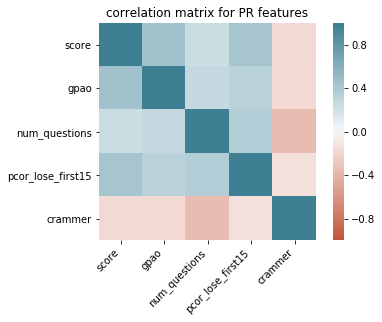

CHEM130 Exam 1 ridge NMAE: -13.409024069894539


<Figure size 432x288 with 0 Axes>

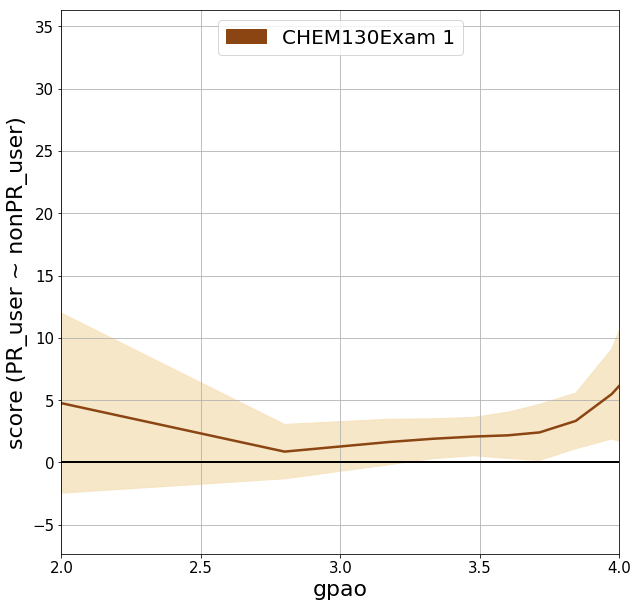

len pr_users: 968
len npr_users: 275


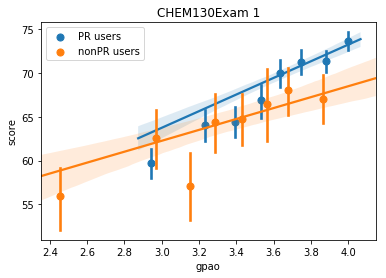

,Feature,Coefficients
0,gpao,15.517075
1,pr_user,4.563775


type 2 anova for CHEM130 exam 1.0 term 2210
                 sum_sq      df           F        PR(>F)
gpao       22539.030603     1.0  272.562033  1.678622e-55
pr_user     1158.780936     1.0   14.013011  1.898658e-04
Residual  102539.585595  1240.0         NaN           NaN


/Users/sethsaps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


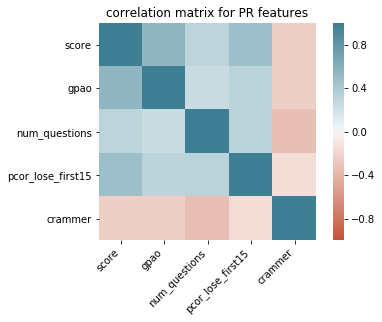

CHEM130 Exam 2 ridge NMAE: -9.238898990307403


<Figure size 432x288 with 0 Axes>

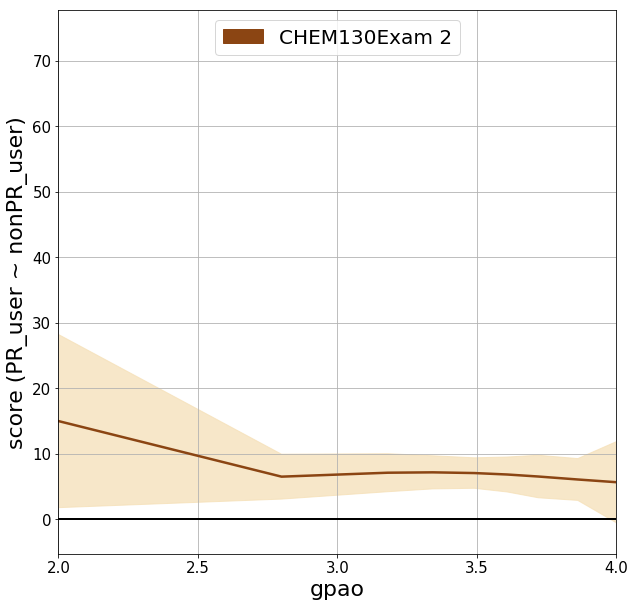

len pr_users: 733
len npr_users: 386


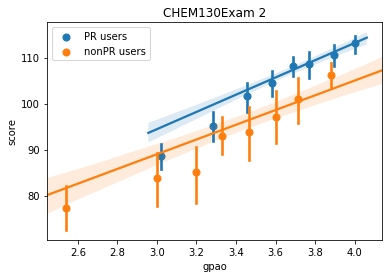

,Feature,Coefficients
0,gpao,13.519412
1,pr_user,5.601358


type 2 anova for CHEM130 exam 2.0 term 2210
                 sum_sq      df           F        PR(>F)
gpao       85132.637610     1.0  391.678069  5.888605e-75
pr_user    11751.923643     1.0   54.068227  3.738914e-13
Residual  242566.615343  1116.0         NaN           NaN


/Users/sethsaps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


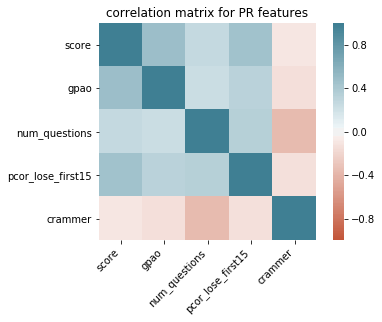

CHEM130 Exam 3 ridge NMAE: -13.486961329995431


<Figure size 432x288 with 0 Axes>

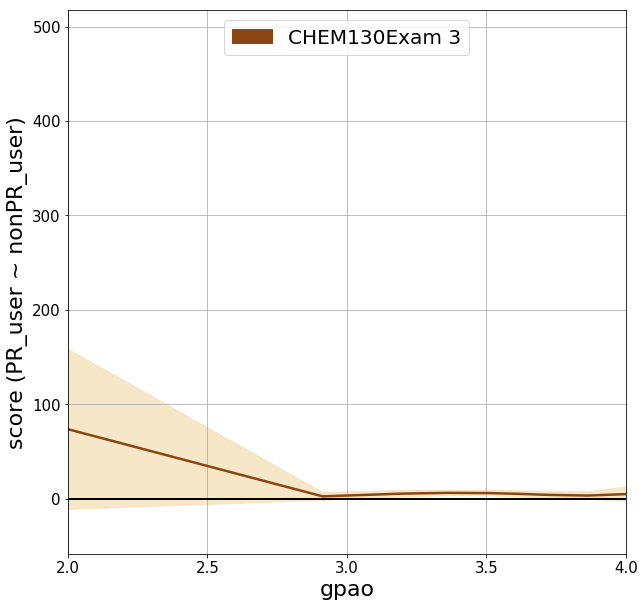

len pr_users: 673
len npr_users: 351


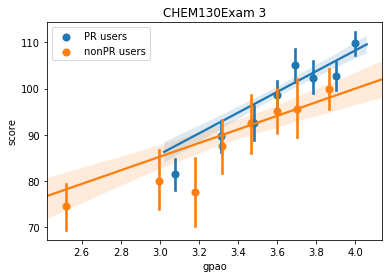

,Feature,Coefficients
0,gpao,14.545412
1,pr_user,3.528635


type 2 anova for CHEM130 exam 3.0 term 2210
                 sum_sq      df           F        PR(>F)
gpao       78779.361424     1.0  277.834922  2.338860e-55
pr_user     4160.019903     1.0   14.671340  1.357802e-04
Residual  289501.864579  1021.0         NaN           NaN


/Users/sethsaps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


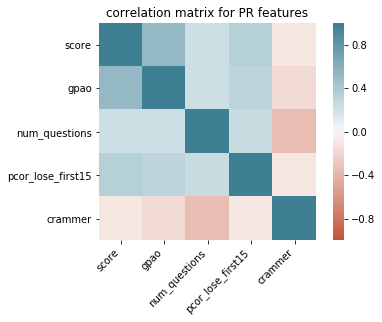

CHEM130 Exam 4 ridge NMAE: -12.753695482673695


<Figure size 432x288 with 0 Axes>

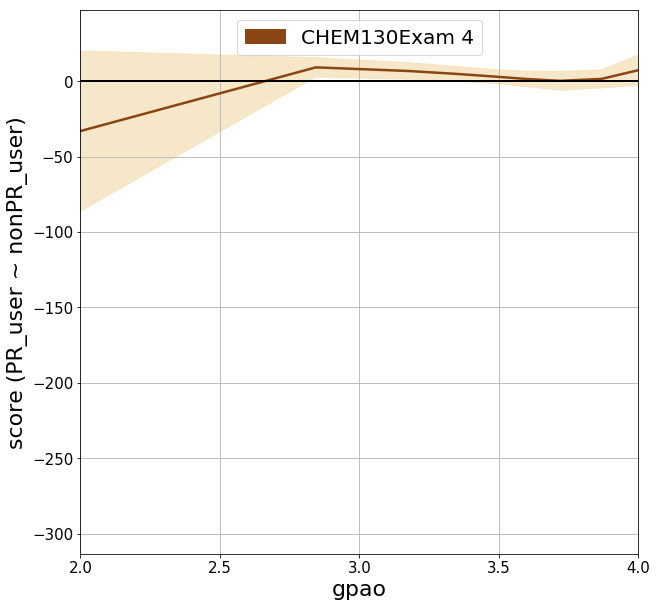

len pr_users: 658
len npr_users: 255


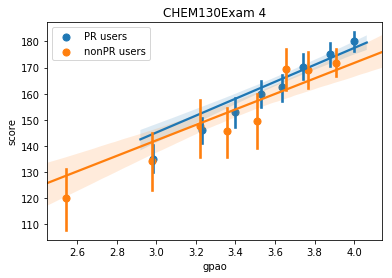

,Feature,Coefficients
0,gpao,14.228336
1,pr_user,1.840288


type 2 anova for CHEM130 exam 4.0 term 2210
                 sum_sq     df           F        PR(>F)
gpao      218559.936174    1.0  373.576792  5.260871e-70
pr_user     2747.749831    1.0    4.696632  3.048057e-02
Residual  532392.660012  910.0         NaN           NaN


/Users/sethsaps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


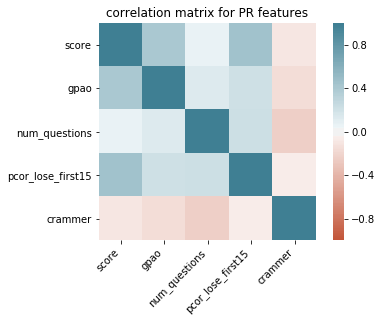

EECS183 Exam 1 ridge NMAE: -14.727722298022558


<Figure size 432x288 with 0 Axes>

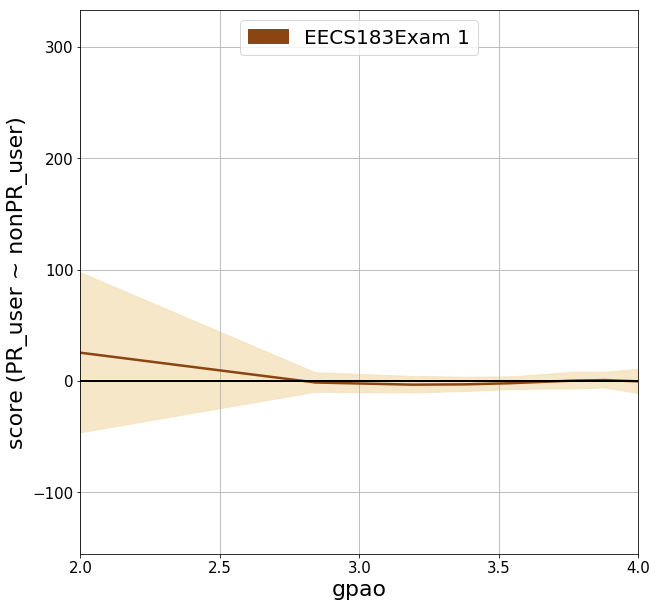

len pr_users: 350
len npr_users: 335


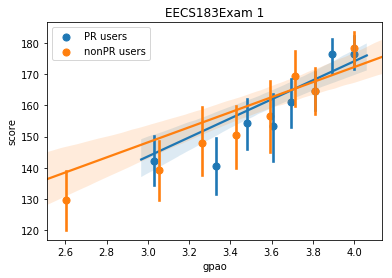

,Feature,Coefficients
0,gpao,16.207968
1,pr_user,-0.242224


type 2 anova for EECS183 exam 1.0 term 2210
                 sum_sq     df           F        PR(>F)
gpao      120118.538050    1.0  143.322806  4.109722e-30
pr_user       21.033665    1.0    0.025097  8.741727e-01
Residual  571582.743954  682.0         NaN           NaN


/Users/sethsaps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


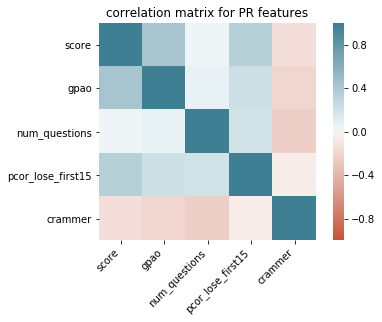

EECS183 Exam 2 ridge NMAE: -9.715450954848446


<Figure size 432x288 with 0 Axes>

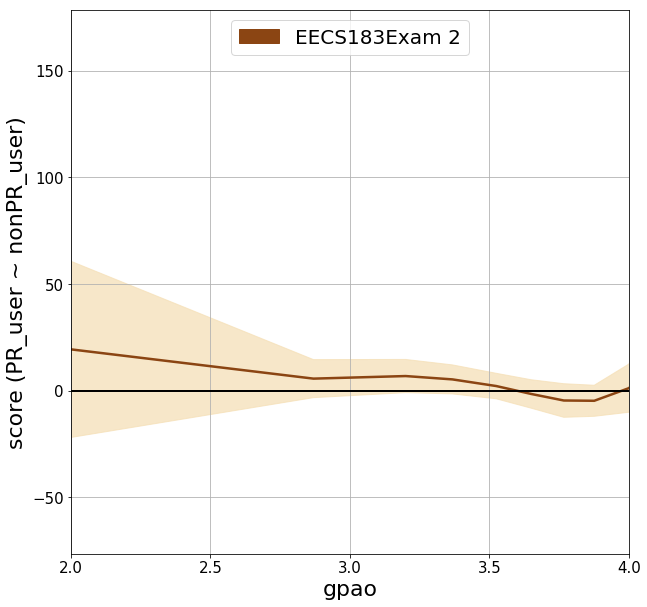

len pr_users: 290
len npr_users: 372


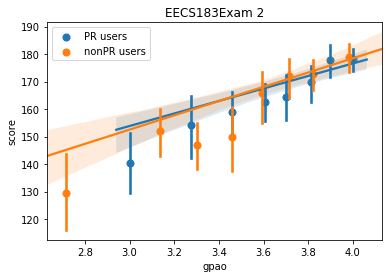

,Feature,Coefficients
0,gpao,13.101785
1,pr_user,0.465163


type 2 anova for EECS183 exam 2.0 term 2210
                 sum_sq     df           F        PR(>F)
gpao      130279.524694    1.0  152.049278  1.395531e-31
pr_user      138.618768    1.0    0.161782  6.876516e-01
Residual  564647.252068  659.0         NaN           NaN


/Users/sethsaps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


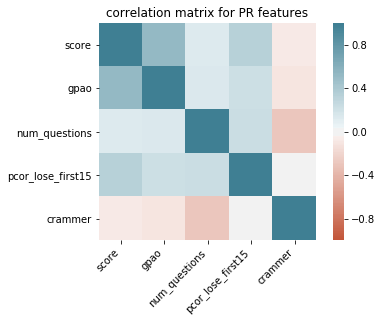

PHYSICS140 Exam 1 ridge NMAE: -15.219599049329535


<Figure size 432x288 with 0 Axes>

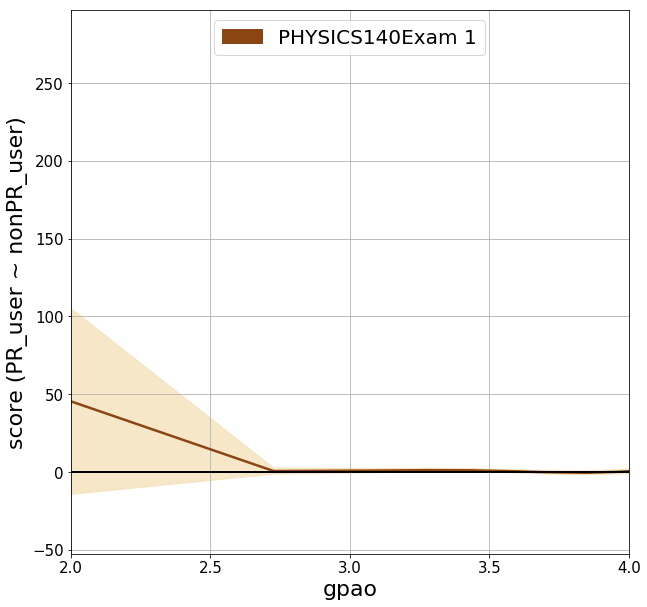

len pr_users: 96
len npr_users: 287


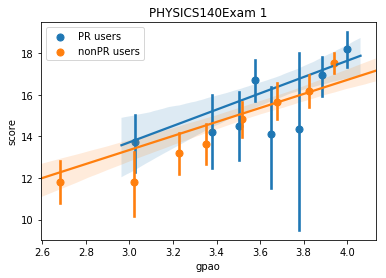

,Feature,Coefficients
0,gpao,16.960501
1,pr_user,2.530289


type 2 anova for PHYSICS140 exam 1.0 term 2210
               sum_sq     df           F        PR(>F)
gpao      1182.386045    1.0  136.819767  3.324349e-27
pr_user     17.856741    1.0    2.066292  1.514101e-01
Residual  3283.931173  380.0         NaN           NaN


/Users/sethsaps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


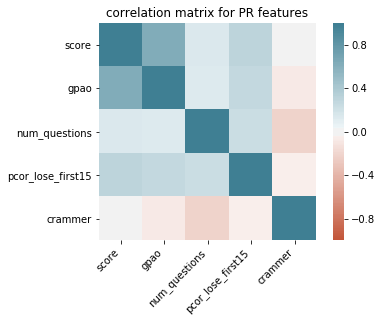

PHYSICS140 Exam 2 ridge NMAE: -15.984557862352782


<Figure size 432x288 with 0 Axes>

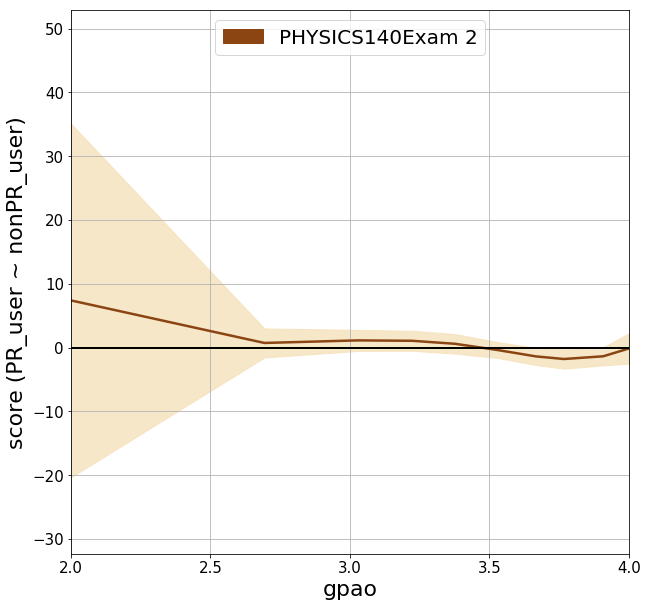

len pr_users: 82
len npr_users: 212


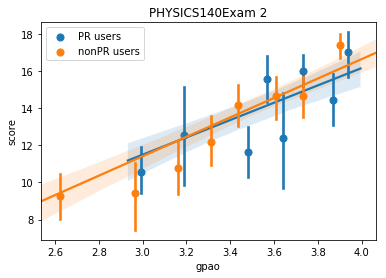

,Feature,Coefficients
0,gpao,24.661689
1,pr_user,-1.331978


type 2 anova for PHYSICS140 exam 2.0 term 2210
               sum_sq     df           F        PR(>F)
gpao      1748.062665    1.0  165.857182  2.429148e-30
pr_user      4.053964    1.0    0.384642  5.356145e-01
Residual  3067.013612  291.0         NaN           NaN


/Users/sethsaps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


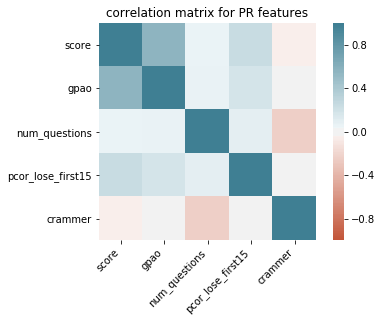

PHYSICS140 Exam 3 ridge NMAE: -14.659121284103867


<Figure size 432x288 with 0 Axes>

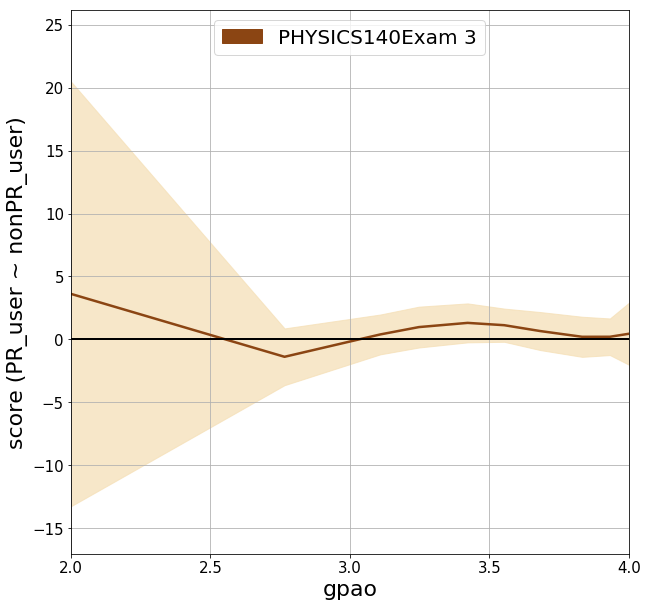

len pr_users: 58
len npr_users: 182


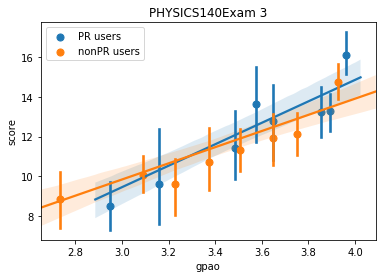

,Feature,Coefficients
0,gpao,21.240689
1,pr_user,2.000949


type 2 anova for PHYSICS140 exam 3.0 term 2210
               sum_sq     df           F        PR(>F)
gpao       913.789649    1.0  109.108504  2.964474e-21
pr_user      6.909723    1.0    0.825036  3.646345e-01
Residual  1984.887880  237.0         NaN           NaN


/Users/sethsaps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


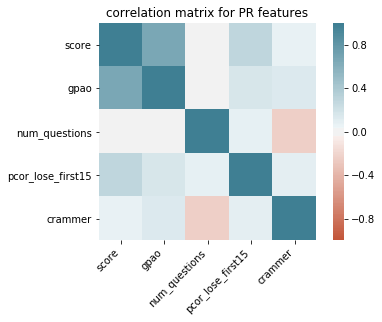

PHYSICS140 Exam 4 ridge NMAE: -17.23064882770845


<Figure size 432x288 with 0 Axes>

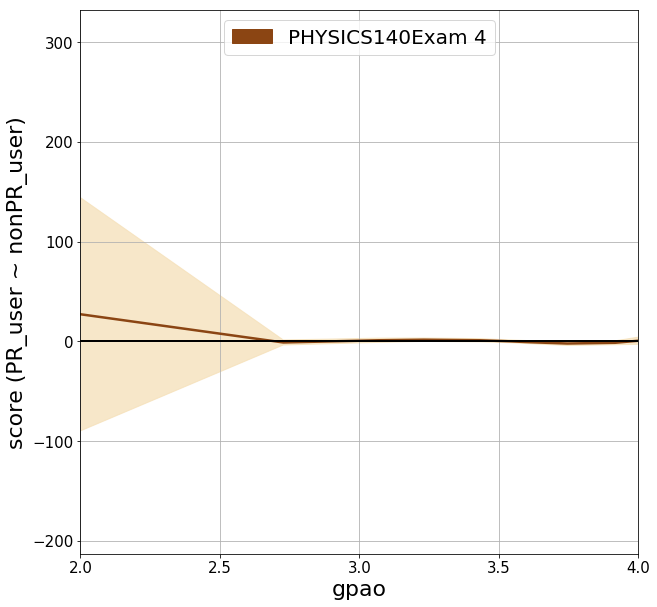

len pr_users: 51
len npr_users: 184


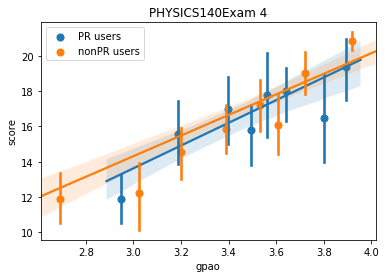

,Feature,Coefficients
0,gpao,23.809871
1,pr_user,-1.540404


type 2 anova for PHYSICS140 exam 4.0 term 2210
               sum_sq     df           F        PR(>F)
gpao      1956.546237    1.0  187.838187  1.023801e-31
pr_user      5.405317    1.0    0.518937  4.720205e-01
Residual  2416.541252  232.0         NaN           NaN


/Users/sethsaps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


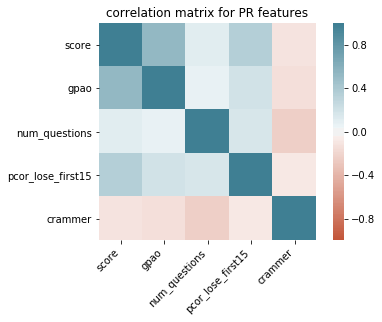

STATS250 Exam 1 ridge NMAE: -7.951178563711007


<Figure size 432x288 with 0 Axes>

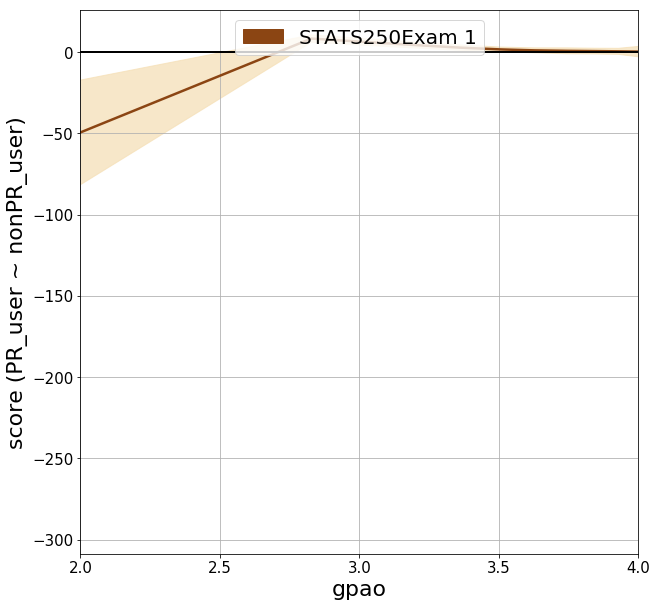

len pr_users: 486
len npr_users: 638


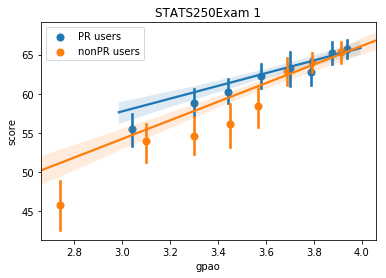

,Feature,Coefficients
0,gpao,14.834930
1,pr_user,3.459748


type 2 anova for STATS250 exam 1.0 term 2210
                sum_sq      df           F        PR(>F)
gpao      32091.380237     1.0  392.663414  3.685217e-75
pr_user    1822.344271     1.0   22.297823  2.630057e-06
Residual  91616.473472  1121.0         NaN           NaN


/Users/sethsaps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


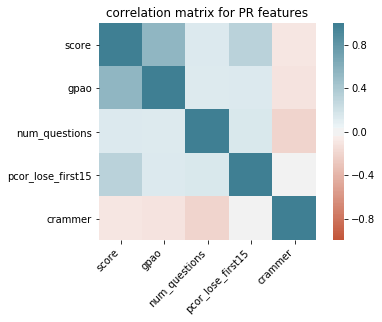

STATS250 Exam 2 ridge NMAE: -13.828361151664804


<Figure size 432x288 with 0 Axes>

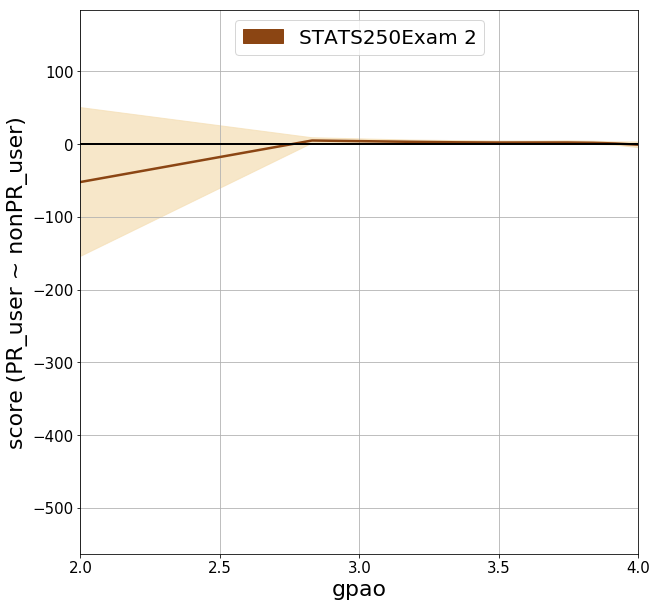

len pr_users: 309
len npr_users: 665


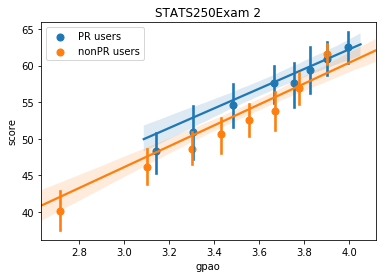

,Feature,Coefficients
0,gpao,17.683675
1,pr_user,3.057554


type 2 anova for STATS250 exam 2.0 term 2210
                sum_sq     df           F        PR(>F)
gpao      36541.135683    1.0  360.169941  1.480666e-68
pr_user    1064.658549    1.0   10.493872  1.238369e-03
Residual  98513.059153  971.0         NaN           NaN


/Users/sethsaps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


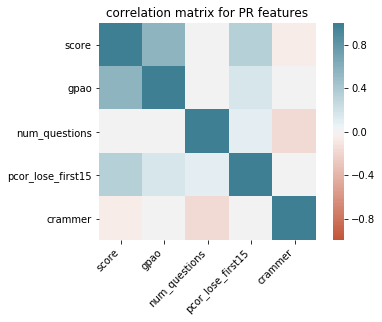

STATS250 Exam 3 ridge NMAE: -12.620732286772675


<Figure size 432x288 with 0 Axes>

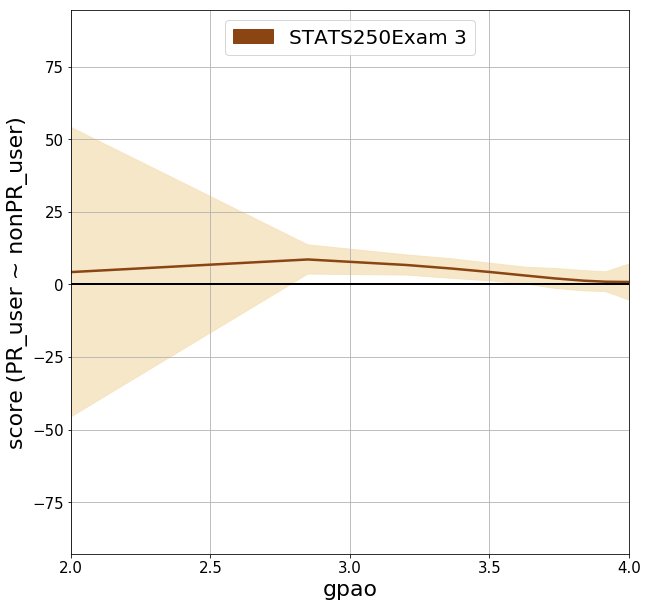

len pr_users: 269
len npr_users: 489


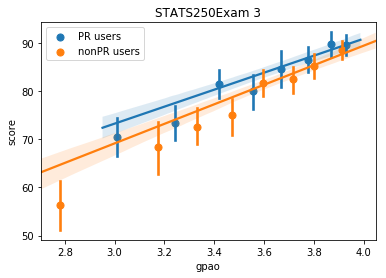

,Feature,Coefficients
0,gpao,21.148671
1,pr_user,3.956376


type 2 anova for STATS250 exam 3.0 term 2210
                 sum_sq     df           F        PR(>F)
gpao       69016.386316    1.0  388.054557  5.023400e-70
pr_user     2690.532476    1.0   15.127906  1.093243e-04
Residual  134278.468611  755.0         NaN           NaN


In [35]:
result_df, to_predict_df, user_prediction_df_dict = predict_for_term()

In [36]:
result_df

,course_code,exam_num,nmae,stat_sig
0,CHEM130,1.0,-13.409024,1
1,CHEM130,2.0,-9.238899,1
2,CHEM130,3.0,-13.486961,1
3,CHEM130,4.0,-12.753695,1
4,EECS183,1.0,-14.727722,0
5,EECS183,2.0,-9.715451,0
6,PHYSICS140,1.0,-15.219599,0
7,PHYSICS140,2.0,-15.984558,0
8,PHYSICS140,3.0,-14.659121,0
9,PHYSICS140,4.0,-17.230649,0


In [37]:
# check out what the heck these scores are out of
exam_scores_winter.groupby(['course_code', 'label'])['score'].describe()

count        mean        std   min    25%    50%  \
course_code label                                                         
CHEM130     Exam 1     564.0   81.402660  13.689559   0.0   74.0   85.0   
            Exam 2     559.0   75.529517  15.828650   0.0   68.0   78.0   
            Exam 3     551.0   71.702359  18.681210   0.0   61.0   73.0   
            Exam 4     548.0  160.600365  29.095049   0.0  148.0  166.0   
DENT613     Exam 1     127.0   38.307087   3.465274  30.0   36.5   39.0   
            Exam 2     127.0   34.598425   3.844724  23.0   32.0   35.0   
EECS183     Exam 1     664.0  168.570783  26.952186  64.0  156.0  177.0   
            Exam 2     620.0  161.156452  29.825227  40.0  145.0  168.0   
MCDB310     Exam 1.1   407.0   58.820639  10.513176  15.0   51.0   60.0   
            Exam 1.2   407.0   59.199017  12.927124   5.0   54.0   62.0   
            Exam 2.1   404.0   56.279703  12.302978  12.0   51.0   57.0   
            Exam 2.2   404.0   51.410891  13.373225   4.0   43.0   54.0   
            Exam 3.1   396.0   59.878788  10.762121   0.0   54.0   63.0   
            Exam 3.2   396.0   59.477273  11.762502   0.0   54.0   62.0   
            Exam 4.1   403.0   54.841191  10.560397  21.0   48.0   57.0   
            Exam 4.2   404.0   54.767327  12.577317   5.0   48.0   58.0   
PHYSICS106  Exam 1      86.0   83.372093  13.501239  34.0   75.0   87.5   
PHYSICS135  Exam 1     398.0   14.532663   3.900228   0.0   12.0   15.0   
            Exam 2     394.0   13.956853   3.954019   0.0   11.0   14.0   
            Exam 3     559.0   30.053667  29.022374   0.0   13.0   17.0   
            Exam 4     388.0   14.438144   4.196564   0.0   12.0   15.0   
PHYSICS140  Exam 1     589.0   15.269949   3.373082   0.0   13.0   16.0   
            Exam 2     585.0   12.034188   3.652574   0.0   10.0   12.0   
            Exam 3     577.0   10.012132   3.794851   0.0    7.0   10.0   
            Exam 4     599.0   15.517529   4.522624   3.0   12.0   16.0   
PHYSICS235  Exam 1     454.0   13.367841   3.924669   0.0   11.0   14.0   
            Exam 2     451.0   15.764967   3.370818   0.0   14.0   17.0   
            Exam 3     889.0   13.572553   3.037226   0.0   12.0   14.0   
            Exam 4     442.0   11.685520   5.970313   0.0   10.0   13.0   
STATS250    Exam 1    1680.0   59.328571  10.315702   0.0   55.0   62.0   
            Exam 2    1630.0   54.008589  12.922916   0.0   46.0   56.0   
            Exam 3    1611.0   82.186840  15.138753   0.0   76.0   87.0   

                         75%    max  
course_code label                    
CHEM130     Exam 1     91.00  100.0  
            Exam 2     86.75  100.0  
            Exam 3     87.00  136.0  
            Exam 4    182.00  232.0  
DENT613     Exam 1     41.00   45.0  
            Exam 2     37.00   43.0  
EECS183     Exam 1    189.00  200.0  
            Exam 2    184.00  200.0  
MCDB310     Exam 1.1   66.00   75.0  
            Exam 1.2   68.00   78.0  
            Exam 2.1   66.00   75.0  
            Exam 2.2   61.00   75.0  
            Exam 3.1   66.00   75.0  
            Exam 3.2   67.00   78.0  
            Exam 4.1   63.00   75.0  
            Exam 4.2   64.00   75.0  
PHYSICS106  Exam 1     94.00   99.0  
PHYSICS135  Exam 1     18.00   20.0  
            Exam 2     17.00   20.0  
            Exam 3     45.00  100.0  
            Exam 4     18.00   20.0  
PHYSICS140  Exam 1     18.00   20.0  
            Exam 2     15.00   20.0  
            Exam 3     12.00   20.0  
            Exam 4     19.00   25.0  
PHYSICS235  Exam 1     16.00   20.0  
            Exam 2     18.00   20.0  
            Exam 3     16.00   20.0  
            Exam 4     16.00   20.0  
STATS250    Exam 1     66.00   75.0  
            Exam 2     64.00   75.0  
            Exam 3     93.00  100.0

In [38]:
# check out what the heck these scores are out of
exam_scores_fall.groupby(['course_code', 'label'])['score'].describe()

count        mean        std   min     25%     50%  \
course_code label                                                           
CHEM130     Exam 1    1373.0   66.301529  10.504170  20.0   60.00   68.00   
            Exam 2    1367.0   98.089978  18.859307   0.0   90.00  100.00   
            Exam 3    1350.0   92.724074  20.075395   0.0   80.00   95.00   
            Exam 4    1347.0  154.854588  30.622497   0.0  136.14  159.81   
EECS183     Exam 1    1018.0  156.013752  31.645651  53.0  135.00  165.00   
            Exam 2     971.0  158.493306  35.421631   0.0  145.00  169.00   
MCDB310     Exam 1.1   400.0   61.710000   8.026329  12.0   57.00   63.00   
            Exam 1.2   400.0   58.165000  11.474840   9.0   53.00   61.00   
            Exam 2.1   396.0   64.166667   8.817273  33.0   57.00   66.00   
            Exam 2.2   396.0   62.515152  10.425250  22.0   57.00   65.00   
            Exam 3.1   346.0   52.442197  13.095120   0.0   45.00   54.00   
            Exam 3.2   345.0   49.684058  15.531154   0.0   39.00   53.00   
            Exam 4.1   396.0   55.265152  11.466535  12.0   48.00   57.00   
            Exam 4.2   397.0   57.853904  13.384705   3.0   51.00   61.00   
PHYSICS106  Exam 1      40.0   91.675000  11.057861  48.0   85.50   96.00   
PHYSICS135  Exam 1     485.0   14.179381   3.740385   2.0   12.00   15.00   
            Exam 2     481.0   14.041580   4.290291   0.0   11.00   15.00   
            Exam 3     464.0   15.383621   5.057278   0.0   13.00   17.00   
            Exam 4     463.0   15.481641   3.921744   0.0   14.00   16.00   
PHYSICS140  Exam 1     672.0   14.431548   3.618723   0.0   12.00   15.00   
            Exam 2     659.0   13.189681   4.023353   0.0   10.50   14.00   
            Exam 3     648.0   11.089506   3.598215   0.0    9.00   11.00   
            Exam 4     663.0   15.731523   4.951458   0.0   13.00   16.00   
PHYSICS160  Exam 1      94.0   15.151596   3.231693   6.5   13.00   15.50   
PHYSICS235  Exam 1     380.0   14.421053   3.948425   0.0   12.00   15.00   
            Exam 2     379.0   15.617414   3.336318   0.0   14.00   16.00   
            Exam 3     376.0   15.776596   3.073861   0.0   14.00   16.00   
            Exam 4     376.0   10.611702   6.804961   0.0    0.00   13.50   
STATS250    Exam 1    1791.0   58.644333  10.932000   0.0   54.00   61.00   
            Exam 2    1724.0   52.608469  12.100007   0.0   45.00   54.00   
            Exam 3    1724.0   77.616589  17.427098   0.0   71.00   82.00   

                         75%    max  
course_code label                    
CHEM130     Exam 1     76.00   80.0  
            Exam 2    110.00  125.0  
            Exam 3    107.50  125.0  
            Exam 4    177.57  219.0  
EECS183     Exam 1    182.00  200.0  
            Exam 2    182.00  200.0  
MCDB310     Exam 1.1   66.00   75.0  
            Exam 1.2   66.00   77.0  
            Exam 2.1   72.00   75.0  
            Exam 2.2   70.00   78.0  
            Exam 3.1   63.00   75.0  
            Exam 3.2   62.00   77.0  
            Exam 4.1   63.00   75.0  
            Exam 4.2   68.00   77.0  
PHYSICS106  Exam 1     98.00  104.0  
PHYSICS135  Exam 1     17.00   20.0  
            Exam 2     17.00   20.0  
            Exam 3     19.00   20.0  
            Exam 4     18.50   20.0  
PHYSICS140  Exam 1     17.00   20.0  
            Exam 2     16.00   20.0  
            Exam 3     14.00   20.0  
            Exam 4     19.00   25.0  
PHYSICS160  Exam 1     18.00   20.0  
PHYSICS235  Exam 1     17.00   20.0  
            Exam 2     18.00   20.0  
            Exam 3     18.00   20.0  
            Exam 4     16.00   20.0  
STATS250    Exam 1     66.00   75.0  
            Exam 2     62.00   75.0  
            Exam 3     90.00  100.0

# CHEM130 Analysis
Per supervisor's request, an analysis was made specifically for chem130 to suggest continued usage of PR.

In [39]:
to_predict_df.head()

,exam_num
course_code,
CHEM130,"[1.0, 2.0, 3.0, 4.0]"
EECS183,"[1.0, 2.0]"
PHYSICS140,"[1.0, 2.0, 3.0, 4.0]"
STATS250,"[1.0, 2.0, 3.0]"


/Users/sethsaps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


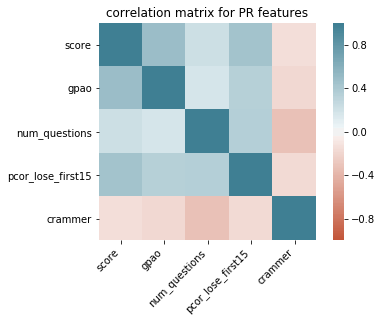

CHEM130 Exam 1 ridge NMAE: -11.061683686225084


<Figure size 432x288 with 0 Axes>

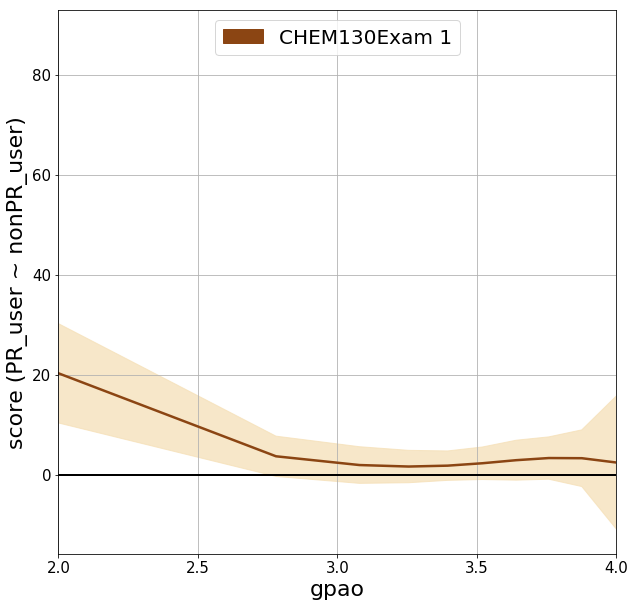

len pr_users: 383
len npr_users: 100


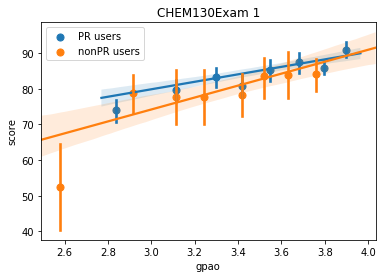

,Feature,Coefficients
0,gpao,12.650508
1,pr_user,3.883659


type 2 anova for CHEM130 exam 1 term 2220
                sum_sq     df           F        PR(>F)
gpao      20720.586580    1.0  181.154279  2.918008e-35
pr_user    1164.339515    1.0   10.179494  1.513106e-03
Residual  54902.824275  480.0         NaN           NaN


/Users/sethsaps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


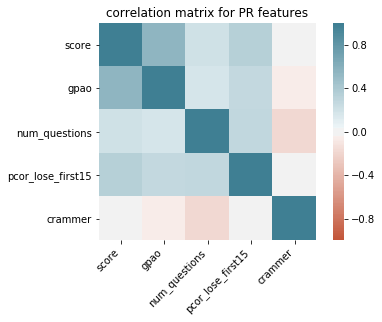

CHEM130 Exam 2 ridge NMAE: -10.080501930430236


<Figure size 432x288 with 0 Axes>

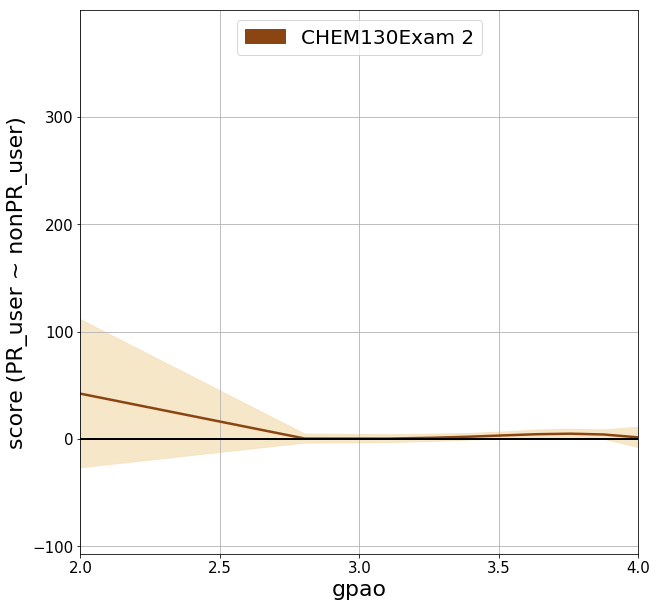

len pr_users: 266
len npr_users: 164


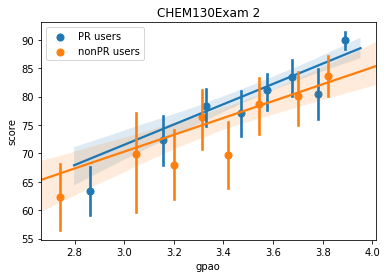

,Feature,Coefficients
0,gpao,16.734897
1,pr_user,2.586650


type 2 anova for CHEM130 exam 2 term 2220
                sum_sq     df           F        PR(>F)
gpao      26054.059775    1.0  196.152254  6.106489e-37
pr_user     666.744583    1.0    5.019696  2.557411e-02
Residual  56716.572366  427.0         NaN           NaN


/Users/sethsaps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


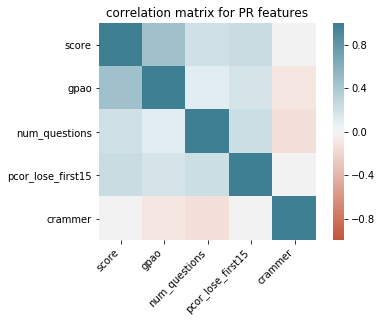

CHEM130 Exam 3 ridge NMAE: -17.111272095004335


<Figure size 432x288 with 0 Axes>

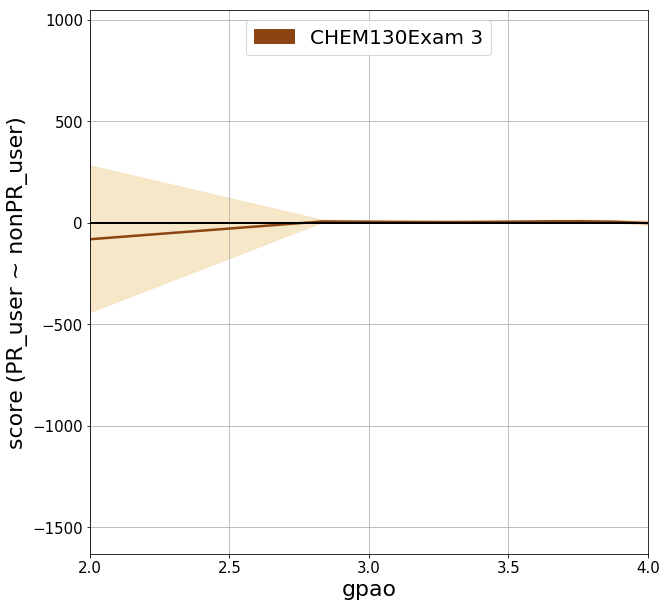

len pr_users: 190
len npr_users: 174


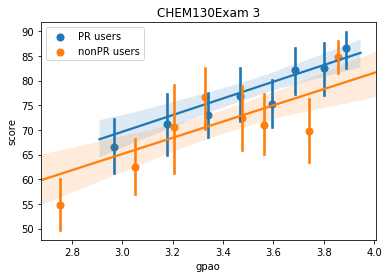

,Feature,Coefficients
0,gpao,20.896340
1,pr_user,6.119924


type 2 anova for CHEM130 exam 3 term 2220
                sum_sq     df          F        PR(>F)
gpao      18644.957025    1.0  95.869612  3.126739e-20
pr_user    1881.184737    1.0   9.672774  2.018900e-03
Residual  70208.164753  361.0        NaN           NaN


/Users/sethsaps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


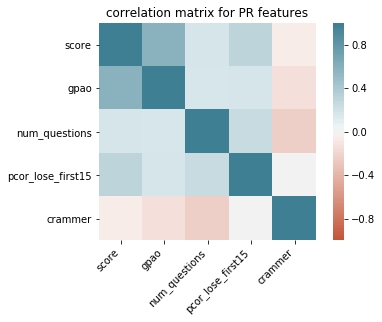

CHEM130 Exam 4 ridge NMAE: -12.906621580648636


<Figure size 432x288 with 0 Axes>

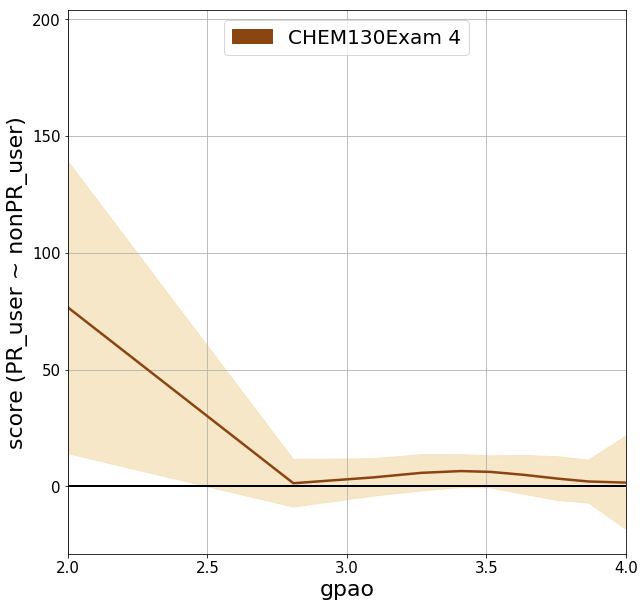

len pr_users: 171
len npr_users: 112


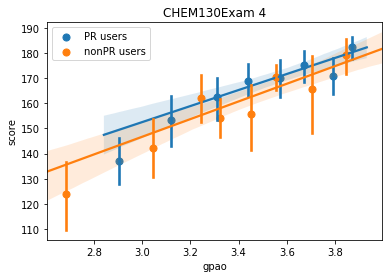

,Feature,Coefficients
0,gpao,23.824136
1,pr_user,3.151967


type 2 anova for CHEM130 exam 4 term 2220
                 sum_sq     df           F        PR(>F)
gpao       63481.547273    1.0  155.397343  1.140455e-28
pr_user     1356.929908    1.0    3.321647  6.943977e-02
Residual  114383.122161  280.0         NaN           NaN


In [40]:
exam_names = ['Exam 1', 'Exam 2', 'Exam 3', 'Exam 4']
pr_counts = []
npr_counts = []
for i in range(4):   
    score, aov, prediction_df = predict_impact('CHEM130', i + 1, 2220, redefine=True)

    # pr vs nonPR user counts
    PR_count = prediction_df['ecoach_id'].count()
    nonPR_count = exam_scores_winter[(exam_scores_winter['course_code']=='CHEM130') & (exam_scores_winter['term_id']==2220) & (exam_scores_winter['label']==exam_names[i])]['ecoach_id'].count() - prediction_df['ecoach_id'].count()
    pr_counts.append(PR_count)
    npr_counts.append(nonPR_count)

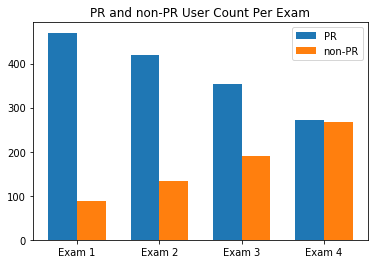

In [41]:
N = 4
fig, ax = plt.subplots()
ind = np.arange(N)
width = 0.35
p1 = ax.bar(ind, tuple(pr_counts), width)
p2 = ax.bar(ind + width, tuple(npr_counts), width)
ax.set_title('PR and non-PR User Count Per Exam')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Exam 1', 'Exam 2', 'Exam 3', 'Exam 4'))
ax.legend((p1[0], p2[0]), ('PR', 'non-PR'))
ax.autoscale_view()
plt.show()

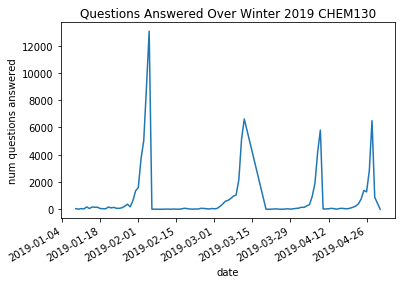

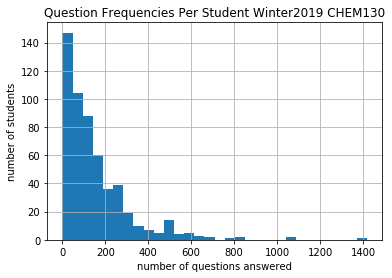

107.0

In [42]:
# get question frequency graph over the entire semester
userquestion_subset = userquestion[userquestion['question_id'].isin(question_topic_course[question_topic_course['course_code']=='CHEM130']['question_id'])]
userquestion_subset = userquestion_subset[(userquestion_subset['modified'] > '2019-1-9') & (userquestion_subset['modified'] < '2019-5-2')]
date_counts = userquestion_subset[['modified']].groupby(userquestion_subset['modified'].dt.floor('d')).size().reset_index(name='count')
fig, ax = plt.subplots()
plt.plot(date_counts['modified'], date_counts['count'])
plt.title('Questions Answered Over Winter 2019 CHEM130')
plt.xlabel('date')
plt.ylabel('num questions answered')
fig.autofmt_xdate()
plt.show()

userquestion_subset.groupby('user_id').count()['modified'].hist(bins=30)
plt.title('Question Frequencies Per Student Winter2019 CHEM130')
plt.xlabel('number of questions answered')
plt.ylabel('number of students')
plt.show()

userquestion_subset.groupby('user_id').count()['modified'].median()

## Dashboard Response and Analytics
Looks to see if those who view the dashboard and then choose their worst topic next have significantly higher exam scores than those who do not look at the dashboard or look at the dashboard but do not do their worst topic next.

In [43]:
# find the actual total questions a user did in each session and merge it
total_questions_per_session = userquestion.groupby('user_session_id').count()[['modified']].rename(columns={'modified':'actual_total_questions'})
usersession = pd.merge(usersession, total_questions_per_session, how='left', left_on='id', right_on='user_session_id')
usersession = usersession[(usersession['mode'] == 'classic') & (usersession['actual_total_questions'].notnull())]

In [44]:
# get only events of users viewing the dashboard
events = events[(events['note'].notnull()) & (events['note'].str.contains('Dashboard'))].drop_duplicates()
events['course_code'] = events['note'].astype(str).apply(lambda x: x.split('/')[1].strip())
events = pd.merge(events[['note', 'timestamp', 'user_id', 'course_code']], question_topic_course[['course_id', 'course_code']].drop_duplicates(), how='left', on='course_code')

In [45]:
reactive_users = []
course_code_for_reactive_users = []
time_for_reactive_users = []

# find out if a user visited their worst topic in the session after viewing the dashboard
for index, row in events.iterrows():
    user_id = row.user_id
    course_id = row.course_id
    dashboard_check_time = row.timestamp
    course_code = row.course_code

    # get relevant sessions for the user that viewed the dashboard
    usersession_subset = usersession[(usersession['course_id'] == course_id) &
                (usersession['user_id'] == user_id) &
                (usersession['mode'] == 'classic') &
                (usersession['actual_total_questions'].notnull())]
    usersession_subset['time_since_dashboard'] = (usersession_subset['created'] - dashboard_check_time).dt.total_seconds()
    usersession_subset = usersession_subset[usersession_subset['time_since_dashboard'] > 0]

    if len(usersession_subset) > 0:
        next_session = usersession_subset.sort_values(by='time_since_dashboard').iloc[0].id
        # find out if the next session has the users worst topic

        # find users worst topic at this point
        userquestion_subset = userquestion[(userquestion['user_id'] == user_id) & (userquestion['modified'] < dashboard_check_time)]
        userquestion_subset = pd.merge(userquestion_subset, question_topic_course, on='question_id', how='left')
        worst_topic = userquestion_subset[userquestion_subset['course_id'] == course_id].groupby('topic_id')['correct'].mean().to_frame()
        if len(worst_topic) > 0:
            worst_topic = worst_topic.index[0]

            # find if questions from that topic are contained in the next session after checking the dashboard
            userquestion_subset = userquestion[userquestion['user_session_id'] == next_session]
            userquestion_subset = pd.merge(userquestion_subset, question_topic_course, how='left', on='question_id')

            # print('worst topic:', worst_topic)
            # print('topics studied in next session:', userquestion_subset.topic_id.unique().tolist())
            
            # if the worst topic is a topic of questions from the next session
            if worst_topic in userquestion_subset.topic_id.unique().tolist():
                reactive_users.append(user_id)
                course_code_for_reactive_users.append(course_code)
                time_for_reactive_users.append(dashboard_check_time)

/Users/sethsaps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [46]:
reactive_users_df = pd.DataFrame(data={'pr_id':reactive_users,
                                       'course_code':course_code_for_reactive_users,
                                       'timestamp':time_for_reactive_users})
exam_nums = []

# find the users next exam after they checked the dashboard
for index, row in reactive_users_df.iterrows():
    exam_dates_subset = exam_dates[(exam_dates['course_code'] == row.course_code) & (exam_dates['term_id'] == 2210)].sort_values(by='exam_date')
    exam_dates_subset = exam_dates_subset[exam_dates_subset['exam_date'] > row.timestamp]
    if not exam_dates_subset.empty:
        exam_nums.append(exam_dates_subset.iloc[0].exam_num)
    else:
        exam_nums.append(np.nan)

reactive_users_df['exam_num'] = exam_nums

In [47]:
# drop users where there was no "next exam"
reactive_users_df = reactive_users_df.dropna()
reactive_users_df = reactive_users_df.drop(columns=['timestamp']).drop_duplicates()

In [48]:
# only use courses where there's at least 20 unique users that reacted to the dashbaord
num_reactive_users_df = reactive_users_df.groupby(['course_code', 'exam_num']).count()
reactive_user_counts = num_reactive_users_df[num_reactive_users_df['pr_id'] > 20].rename(columns={'pr_id':'count'})

In [49]:
# subsets and labels reactive users if that exam had more than 20 reactive users
reactive_users_df = pd.merge(reactive_users_df, reactive_user_counts, how='left', on=['course_code', 'exam_num']).dropna().drop(columns=['count'])
reactive_users_df['reactive'] = 1

In [50]:
# find unique course_code/exam_num to iterate over
course_exam_df = reactive_users_df[['course_code', 'exam_num']].drop_duplicates().sort_values(by=['course_code', 'exam_num'])

In [51]:
reactive_results = []
# loop all course/exam that have at least 20 users that viewed the dashboard
for index, row in course_exam_df.iterrows():
    course_code = row.course_code
    exam_num = row.exam_num
    
    # merge reactive to the user_prediction_df for the course/exam/term
    reactive_users_subset = reactive_users_df[(reactive_users_df['course_code'] == course_code) & (reactive_users_df['exam_num'] == exam_num)]
    user_prediction_df = pd.merge(user_prediction_df_dict[(course_code, exam_num, 2210)], reactive_users_subset[['pr_id', 'reactive']], how='left', on='pr_id')
    user_prediction_df['reactive'] = user_prediction_df['reactive'].fillna(0)

    # type 2 anova test
    mod = ols('score ~ gpao + reactive', data=user_prediction_df[['score', 'gpao', 'reactive']]).fit()
    aov_table = sm.stats.anova_lm(mod, typ=2)
    print('type 2 anova for ' + course_code + ' exam ' + str(exam_num) + ' term ' + '2220')
    print(aov_table)
    
    if aov_table['PR(>F)']['reactive'] < 0.05:
        reactive_results.append(1)
    else:
        reactive_results.append(0)

course_exam_df['reactive_is_significant'] = reactive_results

In [52]:
course_exam_df

,course_code,exam_num,reactive_is_significant


## Dashboard-Related User Behavior
This analysis will see whether users who view the dashboard will choose their worst topic in their next session more often than those who do not view the dashboard. Also looks at what percent of people view the dashboard in general.

In [53]:
non_dashboard_sessions = usersession[usersession['user_id'].isin(events['user_id'].unique()) == False]

In [54]:
non_dashboard_session_samples = non_dashboard_sessions.groupby('id').count().sample(4000).index

In [55]:
dashboard_sessions = []
for index, row in events.iterrows():
    next_sessions = usersession[(usersession['user_id'] == row.user_id) & (usersession['course_id'] == row.course_id) & (usersession['start_time'] > row.timestamp)].sort_values(by='start_time')
    if len(next_sessions) > 0:
        dashboard_sessions.append(next_sessions.iloc[0].id)

In [56]:
def get_percent_does_worst_next(sessions):
    next_has_worst = []
    for session in sessions:
        session = usersession[usersession['id'] == session].iloc[0]
        start_time = session.start_time
        course_id = session.course_id
        user_id = session.user_id
        user_session_id = session.id

        userquestion_subset = userquestion[(userquestion['modified'] < start_time)
                     & (userquestion['user_id'] == user_id)
                     & (userquestion['question_id'].isin(question_topic_course[question_topic_course['course_id'] == course_id].question_id.unique()))]

        userquestion_subset = pd.merge(userquestion_subset, question_topic_course[question_topic_course['course_id'] == course_id], how='left', on='question_id')
        worst_topic = userquestion_subset.groupby('topic_id')[['correct']].mean().sort_values(by='correct')

        if not worst_topic.empty:
            worst_topic = worst_topic.iloc[0].name
            questions_in_session = pd.merge(userquestion[userquestion['user_session_id'] == user_session_id], question_topic_course[question_topic_course['course_id'] == course_id], how='left', on='question_id')
            if worst_topic in questions_in_session.topic_id.unique():
                next_has_worst.append(1)
            else:
                next_has_worst.append(0)
    return np.array(next_has_worst).sum() / float(len(next_has_worst))

In [57]:
print('percent does worst next for non-dashboard:', get_percent_does_worst_next(non_dashboard_session_samples))
print('percent does worst next for dashboard:', get_percent_does_worst_next(dashboard_sessions))

percent does worst next for non-dashboard: 0.3625439624853458
percent does worst next for dashboard: 0.43842510361160447


In [58]:
percent_viewed_dash = events.user_id.nunique() / float(userquestion.user_id.nunique())
print('percent of users that have visited the dashboard:', percent_viewed_dash)

percent of users that have visited the dashboard: 0.22999389126450825


# Playbook Analysis
According to hypothesis 5, those who do not use PR may use other resources. This analysis looks to compare the resource usage of PR vs non-PR users.

In [59]:
ep_exam_playbook = pd.read_csv('./data/EP_exam_playbook.csv')
ep_account_playbook = pd.read_csv('./data/EP_account_playbook.csv')
ep_coach_examresource = pd.read_csv('./data/EP_coach_examresource.csv')
ep_accountexamstrategyresource = pd.read_csv('./data/EP_accountexamstrategyresource.csv', usecols=['id', 'resource_id', 'justification', 'selected', 'usage_amount', 'used', 'usefulness', 'playbook_id'])

In [60]:
# join the resource name and coach_id to selections of that resource
ep_accountexamstrategyresource = pd.merge(ep_accountexamstrategyresource, ep_coach_examresource[['id', 'resource', 'coach_id', 'key']], how='left', left_on='resource_id', right_on='id').drop(columns=['id_x', 'id_y'])

In [61]:
playbook_df = pd.merge(ep_account_playbook[['id', 'playbook_id', 'user_id']], ep_exam_playbook[['id', 'source', 'coach_id', 'exam_id']], how='left', left_on='playbook_id', right_on='id').rename(columns={'playbook_id':'exam_playbook_id', 'id_x':'playbook_id'}).drop(columns=['id_y'])

In [62]:
resources_df = pd.merge(ep_accountexamstrategyresource, playbook_df, how='left', on=['playbook_id', 'coach_id'])

In [63]:
resources_df = resources_df[resources_df['selected'].notnull()]

In [64]:
PR_resources_subset = resources_df[resources_df['playbook_id'].isin(resources_df[resources_df['key'] == 'PR'].playbook_id.unique())]
nonPR_resources_subset = resources_df[(resources_df['playbook_id'].isin(resources_df[resources_df['key'] == 'PR'].playbook_id.unique()) == False) & (resources_df['exam_id'].isin(PR_resources_subset.exam_id.unique()))]

In [ ]:
pr_avg_selected = PR_resources_subset.groupby(['exam_id', 'exam_playbook_id', 'user_id']).count()[['key']].mean(level=0).rename(columns={'key':'PR_avg_selected'})
npr_avg_selected = nonPR_resources_subset.groupby(['exam_id', 'exam_playbook_id', 'user_id']).count()[['key']].mean(level=0).rename(columns={'key':'nonPR_avg_selected'})

In [ ]:
pd.merge(npr_avg_selected, pr_avg_selected, on='exam_id')

In [ ]:
nonPR_grouped = nonPR_resources_subset.groupby(['exam_id', 'key']).count()[['user_id']].rename(columns={'user_id':'nonPR_user'})
PR_grouped = PR_resources_subset.groupby(['exam_id', 'key']).count()[['user_id']].rename(columns={'user_id':'PR_user'})

In [ ]:
nonPR_user_counts = nonPR_resources_subset.groupby(['exam_id', 'user_id']).count().count(level=0)[['resource_id']].rename(columns={'resource_id':'nonPR_user_count'})
PR_user_counts = PR_resources_subset.groupby(['exam_id', 'user_id']).count().count(level=0)[['resource_id']].rename(columns={'resource_id':'PR_user_count'})

In [ ]:
pd.merge(nonPR_user_counts, PR_user_counts, on='exam_id')

In [ ]:
nonPR_grouped = pd.merge(nonPR_grouped.reset_index(), nonPR_user_counts, how='left', on='exam_id')
nonPR_grouped['nonPR_user'] = nonPR_grouped['nonPR_user'] / nonPR_grouped['nonPR_user_count']
nonPR_grouped = nonPR_grouped.drop(columns=['nonPR_user_count'])

PR_grouped = pd.merge(PR_grouped.reset_index(), PR_user_counts, how='left', on='exam_id')
PR_grouped['PR_user'] = PR_grouped['PR_user'] / PR_grouped['PR_user_count']
PR_grouped = PR_grouped.drop(columns=['PR_user_count'])

In [ ]:
compare_usage_df = pd.merge(nonPR_grouped, PR_grouped, how='outer', on=['exam_id', 'key'])

In [ ]:
for name, group in compare_usage_df.groupby('exam_id'):
    if name not in [116, 117, 118, 119, 121, 122, 123]:
        group.index = group['key']
        group[['nonPR_user', 'PR_user']].plot.bar()
        plt.title('exam ' + str(int(name)))
        plt.xlabel('resource')
        plt.ylabel('percent self-reported use')
        plt.xticks(rotation=60)
        plt.show()

# Anova Testing Study Methods
We're looking to determine if reported use of any distinct study resrouces suggest significant impacts on exam scores.

In [ ]:
exam_linker_df = pd.read_csv('./data/exam_playbook_exam_grade_components_2220.csv')
exam_scores_df = pd.read_csv('./data/gradebook_assignmentscore_exams_only_2220.csv')

In [ ]:
exam_scores_df = pd.merge(exam_scores_df[['score', 'assignment_id', 'user_id']], exam_linker_df.drop(columns=['id']), how='left', on='assignment_id')

In [ ]:
# anova test for each type of resource for each exam

# get all users for an exam
exam_users = resources_df.groupby(['exam_id']).user_id.unique()
# create matrix of all users and topics with binary indicators
for i in range(len(exam_users)):
    term_id = 2220
    exam_users_resources = resources_df[(resources_df['exam_id'] == exam_users.index[i]) & (resources_df['user_id'].isin(exam_users.iloc[i]))] 
    empty_count = exam_users_resources[['user_id', 'key']].groupby(['user_id', 'key']).count()
    empty_count['use'] = 1
    user_key_use_df = empty_count.unstack().fillna(0)
    exam_id = exam_users.index[i]
    user_key_use_df = user_key_use_df.reset_index()
    user_key_use_df = pd.merge(user_key_use_df, exam_scores_df[exam_scores_df['exam_id'] == exam_id][['user_id', 'score']], how='left', on='user_id')
    user_key_use_df = user_key_use_df.dropna()

    source_exam = playbook_df[['source', 'exam_id']].drop_duplicates()
    
    # append gpao to matrix for each user for that course
    if not source_exam[source_exam['exam_id'] == exam_users.index[i]].empty:
        source = source_exam[source_exam['exam_id'] == exam_users.index[i]].iloc[0].source
        source = source.upper()
        gpao_subset = gpao[(gpao['TERM_CD'] == 2220) & (gpao['default_source'] == source)]
        print(source)
        # type 2 anova test each resource with gpao on exam scores
        if not gpao_subset.empty and not user_key_use_df.empty:
            user_key_use_df = pd.merge(user_key_use_df, gpao_subset[['ecoach_id', 'gpao']], how='left', left_on='user_id', right_on='ecoach_id')
            user_key_use_df = user_key_use_df[user_key_use_df['gpao'].notnull()]
            factors = str(user_key_use_df.columns[2:-3]).replace("('use', ", "").split("'")[1::2][:-1]
            user_key_use_df.columns = ['user_id', 'user_id2'] + factors + ['score', 'ecoach_id', 'gpao']
            reg = 'score ~ gpao + ' + ' + '.join(factors)
            
            print('num users:', len(user_key_use_df))
            
            mod = ols(reg, data=user_key_use_df).fit()
            aov_table = sm.stats.anova_lm(mod, typ=2)
            print('type 2 anova for ' + source + ' exam ' + str(exam_id) + ' term ' + '2220')
            print(aov_table)
            

# Course Grade Analysis

We're now going to look at using course grades rather than exam grades to see if the implications of using PR has changed, holding gpao constant. This involves looking at anova testing as well as grouped regressions.

In [ ]:
all_grades = pd.read_csv('./data/all_grades_pr.csv')

In [ ]:
all_grades = all_grades.rename(columns={'SBJCT_CD||CATLG_NBR':'course_code',
                           'TERM_CD':'term',
                           'EXCL_CLASS_CUM_GPA':'gpao',
                           'CRSE_GRD_INPUT_CD':'letter_grade'})

In [ ]:
# filter out atypical grades
all_grades = all_grades[all_grades['letter_grade'].isin(['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-', 'E'])]

In [ ]:
def merge_for_user_course_info(userquestion, question_topic_course, all_grades, redefine=True):
    '''Returns a dataframe of all users in each course each term along
       with their gpao, num questions, grade, etc.'''
    # get course for each question
    userquestion_merged = pd.merge(userquestion, question_topic_course[['question_id', 'course_code']].drop_duplicates(), how='left', on='question_id')

    # assign terms to questions
    start_fall = pd.to_datetime('2018-9-3', infer_datetime_format=True)
    end_fall = pd.to_datetime('2018-12-18', infer_datetime_format=True)
    start_winter = pd.to_datetime('2019-1-9', infer_datetime_format=True)
    end_winter = pd.to_datetime('2019-5-5', infer_datetime_format=True)
    userquestion_merged['term'] = -1
    userquestion_merged.loc[(userquestion_merged['modified'] > start_fall) & (userquestion_merged['modified'] < end_fall), 'term'] = 2210
    userquestion_merged.loc[(userquestion_merged['modified'] > start_winter) & (userquestion_merged['modified'] < end_winter), 'term'] = 2220
    userquestion_merged = userquestion_merged[userquestion_merged['term'] != -1]

    # get num questions for each user in each course each term
    userquestion_counts = userquestion_merged.groupby(['term', 'course_code', 'user_id']).count()[['modified']].rename(columns={'modified':'num_questions'})

    # redefine pr_user based on num questions <50
    if redefine:
        userquestion_counts = userquestion_counts[userquestion_counts['num_questions'] > 50]
    userquestion_counts = userquestion_counts.reset_index()

    userquestion_counts = userquestion_counts.rename(columns={'user_id':'pr_id'})

    # merge question count to grades
    user_info = pd.merge(all_grades, userquestion_counts, how='left', on=['term', 'course_code', 'pr_id'])
    
    # get percent correct for each user in each course each term
    userquestion_pcor = userquestion_merged.groupby(['term', 'course_code', 'user_id']).mean()[['correct']].rename(columns={'correct':'pcor'})
    userquestion_pcor = userquestion_pcor.reset_index()
    userquestion_pcor = userquestion_pcor.rename(columns={'user_id':'pr_id'})

    # merge percent correct to grades
    user_info = pd.merge(user_info, userquestion_pcor, how='left', on=['term', 'course_code', 'pr_id'])
    
    def convert_grades(user_info):
        # turn grades into numerical equivalents
        user_info['grade'] = -1
        user_info.loc[user_info['letter_grade'] == 'A+', 'grade'] = 4.0
        user_info.loc[user_info['letter_grade'] == 'A', 'grade'] = 4.0
        user_info.loc[user_info['letter_grade'] == 'A-', 'grade'] = 3.7
        user_info.loc[user_info['letter_grade'] == 'B+', 'grade'] = 3.3
        user_info.loc[user_info['letter_grade'] == 'B', 'grade'] = 3.0
        user_info.loc[user_info['letter_grade'] == 'B-', 'grade'] = 2.7
        user_info.loc[user_info['letter_grade'] == 'C+', 'grade'] = 2.3
        user_info.loc[user_info['letter_grade'] == 'C', 'grade'] = 2.0
        user_info.loc[user_info['letter_grade'] == 'C-', 'grade'] = 1.7
        user_info.loc[user_info['letter_grade'] == 'D+', 'grade'] = 1.3
        user_info.loc[user_info['letter_grade'] == 'D', 'grade'] = 1.0
        user_info.loc[user_info['letter_grade'] == 'D-', 'grade'] = 0.7
        user_info.loc[user_info['letter_grade'] == 'E', 'grade'] = 0.0
        
        return user_info
    
    user_info = convert_grades(user_info)
    
    # assign pr_user and non pr_user
    user_info['pr_user'] = 1
    user_info.loc[user_info['num_questions'].isnull(), 'pr_user'] = 0
    
    return user_info

In [ ]:
def reg_plot_grouped(user_info_):
    '''Graph out a linear regression of gpao on course grade
       with binned gpao and CIs for each course each term'''

    grouped = user_info_.groupby(['course_code', 'term'])
    for name, group in grouped:
        course_code = name[0]
        term = name[1]

        pr_data = group[group['pr_user'] == 1]
        npr_data = group[group['pr_user'] == 0]

        if len(pr_data) > 20 and len(npr_data) > 20:
            ax = sns.regplot(x='gpao', y='grade', data=pr_data, robust=True, x_bins=8, label='PR users')
            ax = sns.regplot(x='gpao', y='grade', data=npr_data, robust=True, x_bins=8, label='nonPR users')
            print('pr_users:', len(pr_data))
            print('npr_users:', len(npr_data))
            term = ''
            if name[1] == 2210:
                term = "Fall '18"
            else:
                term = "Winter '19"
            
            plt.title(name[0] + ' ' + term)
            ax.legend(loc=2)
            plt.show()

In [ ]:
def anova_test_PR_usage(user_info_):
    ''' Anova test for each course each term along with the avg
        difference in grade to see the impact of pr usage on grades.'''
    course_codes = []
    terms = []
    p_vals = []
    pr_users = []
    npr_users = []
    grade_differences = []
    
    grouped = user_info_.groupby(['course_code', 'term'])
    
    for name, group in grouped:
        course_code = name[0]
        term = name[1]
        
        pr_data = group[group['pr_user'] == 1]
        npr_data = group[group['pr_user'] == 0]
        
        # make sure there are some PR and nonPR users
        if not pr_data.empty and not npr_data.empty:
        
            # Anova test
            reg = 'grade ~ gpao + pr_user'
            mod = ols(reg, data=group).fit()
            aov_table = sm.stats.anova_lm(mod, typ=2)
            # print('type 2 anova for term ' + str(term) + ' course ' + str(course_code))
            # print(aov_table)

            p_vals.append(aov_table['PR(>F)'][1])
            course_codes.append(course_code)
            terms.append(term)
            pr_users.append(len(pr_data))
            npr_users.append(len(npr_data))


            # Linear regression to get average difference of pr_user and nonPR_user
            linear = LinearRegression()
            group = group[(group['gpao'].notnull()) & (group['pr_user'].notnull()) & (group['grade'].notnull())]
            x = group[['gpao', 'pr_user']].values
            y = group[['grade']].values.reshape(-1, 1)
            linear.fit(x, y)

            grade_differences.append(np.transpose(linear.coef_[0,][1]))
        
            
    anova_results = pd.DataFrame(data={'course_code':course_codes,
                       'term': terms,
                       'p_val':p_vals,
                       'num_pr_users':pr_users,
                       'num_npr_users':npr_users,
                       'grade_difference':grade_differences})
    anova_results = anova_results.dropna()
    anova_results['significant'] = 0
    anova_results.loc[anova_results['p_val'] < 0.05, 'significant'] = 1
    anova_results.loc[anova_results['grade_difference'] == 0.0, 'grade_difference'] = np.nan
    
    
    return anova_results

In [ ]:
def anova_test_PR_volume(user_info_):
    low_users = []
    high_users = []
    p_vals = []
    course_codes = []
    grade_differences = []
    terms = []

    grouped = user_info_.groupby(['course_code', 'term'])

    for name, group in grouped:
        course_code = name[0]
        term = name[1]

        low_group = group[group['no_vs_low'] == 0]
        high_group = group[group['no_vs_low'] == 1]

        if len(low_group) > 20 and len(high_group) > 20:
            # Anova test
            reg = 'grade ~ gpao + no_vs_low'
            mod = ols(reg, data=group).fit()
            aov_table = sm.stats.anova_lm(mod, typ=2)

            p_vals.append(aov_table['PR(>F)'][1])
            course_codes.append(course_code)
            terms.append(term)
            low_users.append(len(low_group))
            high_users.append(len(high_group))


            # Linear regression to get average difference of pr_user and nonPR_user
            linear = LinearRegression()
            group = group[(group['gpao'].notnull()) & (group['grade'].notnull())]
            x = group[['gpao', 'no_vs_low']].values
            y = group[['grade']].values.reshape(-1, 1)
            linear.fit(x, y)

            grade_differences.append(np.transpose(linear.coef_[0,][1]))

    usage_results = pd.DataFrame(data={'course_code':course_codes,
                       'term': terms,
                       'p_val':p_vals,
                       'num_no_usage_users':low_users,
                       'num_low_users':high_users,
                       'grade_difference':grade_differences})
    usage_results['significant'] = 0
    usage_results.loc[usage_results['p_val'] < 0.05, 'significant'] = 1
    
    return usage_results

In [ ]:
def reg_plot_grouped_by_volume(user_info_):
    '''Graph out a linear regression of gpao on course grade
       with binned gpao and CIs for each course each term'''

    grouped = user_info_.groupby(['course_code', 'term'])
    for name, group in grouped:
        course_code = name[0]
        term = name[1]

        high_data = group[group['no_vs_low'] == 1]
        low_data = group[group['no_vs_low'] == 0]

        if len(high_data) > 20 and len(low_data) > 20:
            ax = sns.regplot(x='gpao', y='grade', data=high_data, robust=True, x_bins=8, label='1 <= num_questions < median')
            ax = sns.regplot(x='gpao', y='grade', data=low_data, robust=True, x_bins=8, label='no usage')
            print('low_use_users:', len(high_data))
            print('no_use_users:', len(low_data))
            plt.title(name)
            ax.legend(loc=2)
            plt.show()

In [ ]:
user_info_redefined = merge_for_user_course_info(userquestion, question_topic_course, all_grades, redefine=False)
user_info_redefined['pr_user'] = 0
course_term_median_questions = user_info_redefined[user_info_redefined['num_questions'].notnull()].groupby(['course_code', 'term']).median()[['num_questions']].reset_index().rename(columns={'num_questions': 'course_median_questions'})
user_info_redefined = pd.merge(user_info_redefined, course_term_median_questions, how='left', on=['course_code', 'term'])
user_info_redefined.loc[user_info_redefined['num_questions'] > user_info_redefined['course_median_questions'], 'pr_user'] = 1

In [ ]:
reg_plot_grouped(user_info_redefined)
anova_PR_usage = anova_test_PR_usage(user_info_redefined)

In [ ]:
ax = sns.regplot(x='gpao', y='grade', data=user_info_redefined, robust=True, x_bins=8)
plt.title('Regression of GPAO on Grades')
plt.show()

In [ ]:
dill.dump_session('dill.env')

In [ ]:
user_info_redefined.info()

In [ ]:
user_info = merge_for_user_course_info(userquestion, question_topic_course, all_grades, redefine=False)
user_info['no_vs_low'] = 1
user_info['pr_user'] = 0
user_info['num_questions'] = user_info['num_questions'].fillna(0)

In [ ]:
user_info = pd.merge(user_info, course_term_median_questions, how='left', on=['course_code', 'term'])

In [ ]:
user_info.loc[user_info['num_questions'] > user_info['course_median_questions'], 'pr_user'] = 1

In [ ]:
user_info = user_info[user_info['pr_user'] == 0]

In [ ]:
user_info.loc[user_info['num_questions'] == 0, 'no_vs_low'] = 0

In [ ]:
reg_plot_grouped_by_volume(user_info)
anova_volume_usage = anova_test_PR_volume(user_info)

In [ ]:
def highlight_significant(s):
    if s.significant == 1:
        return ['background-color: yellow'] * len(s)
    else:
        return ['background-color: white'] * len(s)

In [ ]:
anova_PR_usage.style.apply(highlight_significant, axis=1)

In [ ]:
anova_volume_usage.style.apply(highlight_significant, axis=1)

In [ ]:
question_topic_course[['question_id', 'course_code']].drop_duplicates().groupby('course_code').count().plot.bar()
plt.title('Number of questions per course')
plt.ylabel('num questions')
plt.show()

In [ ]:
question_topic_course[['topic_id', 'course_code']].drop_duplicates().groupby(['course_code']).count().plot.bar()
plt.title('Number of Topics per Course')
plt.ylabel('num topics')
plt.show()

In [ ]:
user_info.dropna().groupby('course_code').median()[['num_questions']].plot.bar()
plt.title('Median Questions Answered Per Course')
plt.ylabel('num questions')

In [ ]:
events[['course_code', 'user_id', 'note']].groupby(['course_code', 'user_id']).count().mean(level=0).plot.bar()
plt.title('Median Dashboard Views Per Course')
plt.ylabel('num views')
plt.show()

In [ ]:
user_info_redefined[user_info_redefined['pr_user'] == 1].pr_id.nunique()

In [ ]:
course_codes = []
terms = []
r_squared_vals = []
num_users = []

grouped = user_info_redefined[user_info_redefined['pr_user'] == 1].groupby(['course_code', 'term'])
for name, group in grouped:
    if len(group) > 10:
        course_code = name[0]
        term = name[1]
        
        # predict exam score

        min_max_scaler = MinMaxScaler()
        y = group['grade'].values.reshape(-1, 1)
        x = group[['num_questions', 'pcor']].values
        x = min_max_scaler.fit_transform(x)

        # calculate nmae based on ridge regression
        ridge = Ridge()
        parameters = {'alpha':[1e-5, 1e-3, 0.01, 1, 5, 10, 100]}
        ridge_regressor = GridSearchCV(ridge, parameters, scoring='r2')
        ridge_regressor.fit(x,y)

        r_squared_vals.append(ridge_regressor.best_score_)
        terms.append(term)
        course_codes.append(course_code)
        num_users.append(len(group))

prediction_results = pd.DataFrame(data={'course_code':course_codes,
                                        'term':terms,
                                        'num_users':num_users,
                                        'r-squared':r_squared_vals})

In [ ]:
prediction_results[prediction_results['num_users'] > 50].groupby(['course_code', 'term']).mean()[['r-squared']].plot.bar()
plt.xticks(rotation=55)
plt.title('R-Squared Course Prediction Values')
plt.show()

In [ ]:
user_info.groupby(['course_code']).median()[['pcor']].plot.bar()
plt.xticks(rotation=55)
plt.title('Percent Correct Median Per Course')
plt.show()

In [ ]:
user_info[(user_info['num_questions'] < 100) & (user_info['num_questions'] > 0)].num_questions.plot.hist(bins=30)
plt.title('Usage Per User Histogram')
plt.xlabel('num questions')
plt.ylabel('frequency')
plt.show()

print('Number Questions Median:', user_info.num_questions.median())

np.log(user_info['num_questions'].dropna()).plot.hist(bins=25)
plt.title('Log Usage Per User Histogram')
plt.xlabel('log num questions')
plt.show()

user_info[(user_info['num_questions'] < 100) & (user_info['num_questions'] > 0)].num_questions.plot.hist(density=True, cumulative=True, histtype='step')
plt.title('Cumulative Density of Number of Questions Per User')
plt.ylabel('percent that do less')
plt.xlabel('num questions')
plt.show()

# Crammer Research

In [ ]:
to_predict_df = exam_dates[(exam_dates['term_id']==2210) & (exam_dates['course_code'].isin(courses_for_analysis))].groupby('course_code')['exam_num'].unique().to_frame()

# use to store df for each exam in each course
# KEY: (course_code, exam_num, term_id), VALUE: user_prediction_df
user_prediction_df_dict = {}

for index, row in to_predict_df.iterrows():
    for exam_num in row.exam_num:
        NMAE, aov_table, user_prediction_df = predict_impact(index, exam_num, 2210, redefine=True)
        user_prediction_df_dict[(index, exam_num, 2210)] = user_prediction_df
        

In [ ]:
merged_df = pd.DataFrame(data={'term':[],
                               'course_code':[],
                               'exam':[],
                               'ecoach_id':[],
                               'pr_id':[],
                               'score':[],
                               'gpao':[],
                               'num_questions':[],
                               'pcor_lose_first15':[],
                               'days_to_exam':[],
                               'crammer':[],
                               'pr_user':[]})

for index, row in to_predict_df.iterrows():
    for exam_num in row.exam_num:
        predict_df = user_prediction_df_dict[(index, exam_num, 2220)]
        predict_df['term'] = 2210
        predict_df['course_code'] = index
        predict_df['exam'] = exam_num
        merged_df = merged_df.append(predict_df, sort=True)

In [ ]:
# merged_df = merged_df[merged_df['num_questions'] > 20]

In [ ]:
grouped = merged_df.groupby(['term', 'course_code', 'exam'])
crammer_df = grouped.mean()[['crammer']].rename(columns={'crammer':'percent_crammers'})

user_counts = grouped.count()[['crammer']].rename(columns={'crammer':'num_PR_users'})
crammer_df = pd.merge(crammer_df, user_counts, on=['term', 'course_code', 'exam'])

In [ ]:
merged_df[merged_df['crammer'] == 0].num_questions.mean()

In [ ]:
crammer_gpao = merged_df[merged_df['crammer'] == 1].gpao.mean()
noncrammer_gpao = merged_df[merged_df['crammer'] == 0].gpao.mean()

crammer_questions = merged_df[merged_df['crammer'] == 1].num_questions.mean()
noncrammer_questions = merged_df[merged_df['crammer'] == 0].num_questions.mean()

crammer_pcor = merged_df[merged_df['crammer'] == 1].pcor_lose_first15.mean()
noncrammer_pcor = merged_df[merged_df['crammer'] == 0].pcor_lose_first15.mean()

plt.title('Crammer GPAOs')
plt.ylabel('gpao')
plt.bar(['crammer', 'noncrammer'], [crammer_gpao, noncrammer_gpao])
plt.show()

plt.title('Crammer Num Questions Answered')
plt.ylabel('num questions')
plt.bar(['crammer', 'noncrammer'], [crammer_questions, noncrammer_questions])
plt.show()

plt.title('Crammer Percent Correct')
plt.ylabel('Percent correct')
plt.bar(['crammer', 'noncrammer'], [crammer_pcor, noncrammer_pcor])
plt.show()

In [ ]:
crammer_df

In [ ]:
crammer_df[['percent_crammers']].plot.bar()
plt.ylabel('percent')
plt.title('Percent Crammers Per Exam')

In [ ]:
crammer_df[['num_PR_users']].plot.bar()
plt.ylabel('number of users')
plt.title('Number of Users Per Exam')

In [ ]:
def reg_plot_grouped_by_crammer(user_info_):
    '''Graph out a linear regression of gpao on course grade
       with binned gpao and CIs for each course each term'''

    grouped = user_info_.groupby(['course_code', 'term', 'exam'])
    for name, group in grouped:
        course_code = name[0]
        term = name[1]

        crammer_data = group[group['crammer'] == 1]
        noncrammer_data = group[group['crammer'] == 0]

        if len(crammer_data) > 20 and len(noncrammer_data) > 20:
            ax = sns.regplot(x='gpao', y='score', data=crammer_data, robust=True, x_bins=4, label='crammer')
            ax = sns.regplot(x='gpao', y='score', data=noncrammer_data, robust=True, x_bins=4, label='not crammer')
            print('high_use_users:', len(crammer_data))
            print('low_use_users:', len(noncrammer_data))
            plt.title(name)
            ax.legend(loc=2)
            plt.show()

In [ ]:
def anova_test_PR_crammer(user_info_):

    p_vals = []
    course_codes = []
    grade_differences = []
    terms = []
    exams = []

    grouped = user_info_.groupby(['course_code', 'term', 'exam'])

    for name, group in grouped:
        course_code = name[0]
        term = name[1]
        exam = name[2]

        noncrammer_group = group[group['crammer'] == 0]
        crammer_group = group[group['crammer'] == 1]

        if len(noncrammer_group) > 20 and len(crammer_group) > 20:
            # Anova test
            reg = 'score ~ gpao + crammer'
            mod = ols(reg, data=group).fit()
            aov_table = sm.stats.anova_lm(mod, typ=2)

            p_vals.append(aov_table['PR(>F)'][1])
            course_codes.append(course_code)
            terms.append(term)
            exams.append(exam)

    usage_results = pd.DataFrame(data={'course_code':course_codes,
                       'term': terms,
                       'exam':exams,
                       'p_val':p_vals})
    usage_results['significant'] = 0
    usage_results.loc[usage_results['p_val'] < 0.05, 'significant'] = 1
    
    return usage_results

In [ ]:
anova_test_PR_crammer(merged_df)

In [ ]:
reg_plot_grouped_by_crammer(merged_df)

In [ ]:
for name, group in merged_df.groupby(['course_code', 'term', 'exam']):
    ax = sns.regplot(x='days_to_exam', y='score', data=group, robust=True, x_bins=4, label='crammer')
    plt.title(name)
    plt.show()

In [ ]:
crammer_dist = merged_df.groupby(['course_code', 'term', 'pr_id']).sum().reset_index()[['course_code', 'crammer']]
crammer_dist.hist(by=crammer_dist['course_code'])
plt.xlabel('num exams crammed for')
plt.ylabel('num users')
plt.show()

In [ ]:
# unique number of students per course
course_user_counts = merged_df.groupby('course_code').nunique()[['pr_id']].rename(columns={'pr_id': 'unique_users'})

used_for_all_exams = []
# unique number of students per course that used PR for every exam
for course in merged_df.course_code.unique():
    subset_merged_df = merged_df[merged_df['course_code'] == course]
    exams = subset_merged_df.exam.unique()
    users = subset_merged_df.pr_id.unique()
    for exam in exams:
        subset_merged_df = subset_merged_df[subset_merged_df['pr_id'].isin(subset_merged_df[subset_merged_df['exam'] == exam].pr_id.unique())]
    used_for_all_exams.append(subset_merged_df.pr_id.nunique())
course_user_counts['used_PR_for_all_exams'] = used_for_all_exams

course_user_counts

In [ ]:
# unique number of students per course
course_user_counts = merged_df.groupby('course_code').nunique()[['pr_id']].rename(columns={'pr_id': 'unique_users'})

used_for_some_exams = []
num_exam_1_crammers = []
num_rehabbed_crammers = []

p_vals = []

# unique number of students per course that used PR for every exam
for course in merged_df.course_code.unique():
    subset_merged_df = merged_df[merged_df['course_code'] == course]
    exams = subset_merged_df.exam.unique()
    users = subset_merged_df.pr_id.unique()
    for exam in [1.0, 2.0]:
        subset_merged_df = subset_merged_df[subset_merged_df['pr_id'].isin(subset_merged_df[subset_merged_df['exam'] == exam].pr_id.unique())]
    used_for_some_exams.append(subset_merged_df.pr_id.nunique())
    
    # get exam 1 crammers
    crammer_exam_1 = subset_merged_df[(subset_merged_df['crammer'] == 1) & (subset_merged_df['exam'] == 1)]
    
    # get exam 2 users that crammed exam 1
    excrammers = subset_merged_df[(subset_merged_df['exam'] == 2) & (subset_merged_df['pr_id'].isin(crammer_exam_1.pr_id.unique()))]
    excrammers['repeat_offender'] = 0
    excrammers.loc[excrammers['crammer'] == 1, 'repeat_offender'] = 1
    
    num_exam_1_crammers.append(len(crammer_exam_1))
    num_rehabbed_crammers.append(len(excrammers[excrammers['repeat_offender'] == 0]))
    
    # anova test if rehabbed crammers do better than those who didn't stop
    reg = 'score ~ gpao + repeat_offender'
    mod = ols(reg, data=excrammers).fit()
    aov_table = sm.stats.anova_lm(mod, typ=2)

    p_vals.append(aov_table['PR(>F)'][1])
    
course_user_counts['used_PR_for_exams_1&2'] = used_for_some_exams
course_user_counts['num_exam_1_crammers'] = num_exam_1_crammers
course_user_counts['num_rehabbed_crammers'] = num_rehabbed_crammers
course_user_counts['anova_rehabbed_p_val'] = p_vals
course_user_counts['significant'] = 0
course_user_counts.loc[course_user_counts['anova_rehabbed_p_val'] < 0.05, 'anova_rehabbed_p_val'] = 1

course_user_counts

In [ ]:
def anova_test(user_info_, reg_, metric_):

    p_vals = []
    course_codes = []
    grade_differences = []
    terms = []
    exams = []

    grouped = user_info_.groupby(['course_code', 'term', 'exam'])

    for name, group in grouped:
        course_code = name[0]
        term = name[1]
        exam = name[2]

        group1 = group[group[metric_] == 0]
        group2 = group[group[metric_] == 1]
        
        if len(group1) > 0 and len(group2) > 0:
            # Anova test
            # reg = 'score ~ gpao + crammer'
            mod = ols(reg, data=group).fit()
            aov_table = sm.stats.anova_lm(mod, typ=2)

            p_vals.append(aov_table['PR(>F)'][1])
            course_codes.append(course_code)
            terms.append(term)
            exams.append(exam)

    usage_results = pd.DataFrame(data={'course_code':course_codes,
                       'term': terms,
                       'exam':exams,
                       'p_val':p_vals})
    usage_results['significant'] = 0
    usage_results.loc[usage_results['p_val'] < 0.05, 'significant'] = 1
    
    return usage_results

In [ ]:
# assign new column of high usage for those who answered > 50 questions
merged_df['high_usage'] = 0
merged_df.loc[merged_df['num_questions'] > 37.5, 'high_usage'] = 1

In [ ]:
low_cram = len(merged_df[(merged_df['crammer'] == 1) & (merged_df['high_usage'] == 0)])
high_cram = len(merged_df[(merged_df['crammer'] == 1) & (merged_df['high_usage'] == 1)])
low_noncram = len(merged_df[(merged_df['crammer'] == 0) & (merged_df['high_usage'] == 0)])
high_noncram = len(merged_df[(merged_df['crammer'] == 0) & (merged_df['high_usage'] == 1)])

In [ ]:
print('User Counts')
usage_crammer_counts = pd.DataFrame(data={'crammer':[low_cram, high_cram,low_cram + high_cram],
                                          'non_crammer':[low_noncram, high_noncram, low_noncram + high_noncram],
                                          'total':[low_cram + low_noncram, high_cram + high_noncram, np.nan]})
usage_crammer_counts.index = ['low usage', 'high usage', 'total']
usage_crammer_counts

In [ ]:
# get mean and stdv for each exam and merge
means = []
stdvs = []
course_codes = []
exams = []
for name, group in merged_df.groupby(['course_code', 'exam']):
    course_codes.append(name[0])
    exams.append(name[1])
    means.append(group.score.mean())
    stdvs.append(group.score.std())
exam_mean_stdv_df = pd.DataFrame(data={'course_code':course_codes,
                   'exam':exams,
                   'mean':means,
                   'stdv':stdvs})
merged_df = pd.merge(merged_df, exam_mean_stdv_df, how='left', on=['course_code', 'exam'])

In [ ]:
merged_df['standard_score'] = (merged_df['score'] - merged_df['mean']) / merged_df['stdv']

In [ ]:
low_cram = merged_df[(merged_df['crammer'] == 1) & (merged_df['high_usage'] == 0)]
high_cram = merged_df[(merged_df['crammer'] == 1) & (merged_df['high_usage'] == 1)]
low_noncram = merged_df[(merged_df['crammer'] == 0) & (merged_df['high_usage'] == 0)]
high_noncram = merged_df[(merged_df['crammer'] == 0) & (merged_df['high_usage'] == 1)]

In [ ]:
low_cram_avg = low_cram.standard_score.mean()
high_cram_avg = high_cram.standard_score.mean()
low_noncram_avg = low_noncram.standard_score.mean()
high_noncram_avg = high_noncram.standard_score.mean()

In [ ]:
print('Standard Score Averages')
usage_crammer_counts = pd.DataFrame(data={'crammer':[low_cram_avg, high_cram_avg,low_cram.append(high_cram).standard_score.mean()],
                                          'non_crammer':[low_noncram_avg, high_noncram_avg, low_noncram.append(high_noncram).standard_score.mean()],
                                          'avg':[low_cram.append(low_noncram).standard_score.mean(), high_cram.append(high_noncram).standard_score.mean(), np.nan]})
usage_crammer_counts.index = ['low usage', 'high usage', 'avg']
usage_crammer_counts

In [ ]:
# label high_crammer, low_crammer, high_noncrammer, low_noncrammer to make anova easier
merged_df['high_crammer'] = 0
merged_df['high_noncrammer'] = 0
merged_df['low_crammer'] = 0
merged_df['low_noncrammer'] = 0
merged_df.loc[(merged_df['crammer'] == 1) & (merged_df['high_usage'] == 0), 'low_crammer'] = 1
merged_df.loc[(merged_df['crammer'] == 1) & (merged_df['high_usage'] == 1), 'high_crammer'] = 1
merged_df.loc[(merged_df['crammer'] == 0) & (merged_df['high_usage'] == 0), 'low_noncrammer'] = 1
merged_df.loc[(merged_df['crammer'] == 0) & (merged_df['high_usage'] == 1), 'high_noncrammer'] = 1

In [ ]:
# Anova test
merged_df_subset = merged_df[merged_df['high_usage'] == 0]
reg = 'standard_score ~ gpao + crammer'
mod = ols(reg, data=merged_df).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)

print(aov_table['PR(>F)'][1])

# Defining a Crammer
Grid search separators for defining crammer and high usage. Then check significance on overall results. Do a similar analysis on a per course basis. Then redo analysis of cramming one exam to user behavior and results.

In [ ]:
to_predict_df = exam_dates[(exam_dates['term_id']==2210) & (exam_dates['course_code'].isin(courses_for_analysis))].groupby('course_code')['exam_num'].unique().to_frame()

# use to store df for each exam in each course
# KEY: (course_code, exam_num, term_id), VALUE: user_prediction_df
user_prediction_df_dict = {}

for index, row in to_predict_df.iterrows():
    for exam_num in row.exam_num:
        NMAE, aov_table, user_prediction_df = predict_impact(index, exam_num, 2210, redefine=True)
        user_prediction_df_dict[(index, exam_num, 2210)] = user_prediction_df

In [ ]:
merged_df = pd.DataFrame(data={'term':[],
                               'course_code':[],
                               'exam':[],
                               'ecoach_id':[],
                               'pr_id':[],
                               'score':[],
                               'gpao':[],
                               'num_questions':[],
                               'pcor_lose_first15':[],
                               'days_to_exam':[],
                               'crammer':[],
                               'pr_user':[]})

for index, row in to_predict_df.iterrows():
    for exam_num in row.exam_num:
        predict_df = user_prediction_df_dict[(index, exam_num, 2210)]
        predict_df['term'] = 2210
        predict_df['course_code'] = index
        predict_df['exam'] = exam_num
        merged_df = merged_df.append(predict_df, sort=True)

In [ ]:
# get mean and stdv for each exam and merge
means = []
stdvs = []
course_codes = []
exams = []
for name, group in merged_df.groupby(['course_code', 'exam']):
    course_codes.append(name[0])
    exams.append(name[1])
    means.append(group.score.mean())
    stdvs.append(group.score.std())
exam_mean_stdv_df = pd.DataFrame(data={'course_code':course_codes,
                   'exam':exams,
                   'mean':means,
                   'stdv':stdvs})
merged_df = pd.merge(merged_df, exam_mean_stdv_df, how='left', on=['course_code', 'exam'])

In [ ]:
# convert score to standard score based on course
merged_df['standard_score'] = (merged_df['score'] - merged_df['mean']) / merged_df['stdv']

In [ ]:
# consider all below median as non-PR and remove them
median_questions_per_course = merged_df.groupby(['term','course_code']).median()[['num_questions']].rename(columns={'num_questions':'median_num_count'})
merged_df = pd.merge(merged_df, median_questions_per_course, how='left', on=['term', 'course_code'])
merged_df = merged_df[merged_df['num_questions'] > merged_df['median_num_count']]

In [ ]:
def define_high_usage(merged_df_, percentile):
    '''returns a dataframe with high usage defined based on percentile between 0 and 1'''
    
    median_questions_per_course = merged_df_.groupby(['term','course_code']).quantile(percentile)[['num_questions']].rename(columns={'num_questions':'xth_percentile_num_count'})
    merged_df_ = pd.merge(merged_df_[['course_code', 'crammer', 'days_to_exam', 'ecoach_id', 'exam', 'gpao',
       'num_questions', 'pcor_lose_first15', 'pr_id', 'pr_user', 'score',
       'term', 'mean', 'stdv', 'standard_score', 'median_num_count']], median_questions_per_course, how='left', on=['term', 'course_code'])
    merged_df_['high_usage'] = 0
    merged_df_.loc[merged_df_['num_questions'] > merged_df_['xth_percentile_num_count'], 'high_usage'] = 1
    
    return merged_df_

In [ ]:
# merged_df = merged_df[merged_df['num_questions'] > 25]

In [ ]:
def anova(data, reg):
    # Anova test
    mod = ols(reg, data=data).fit()
    aov_table = sm.stats.anova_lm(mod, typ=2)

    return aov_table['PR(>F)'][1]

In [ ]:
merged_df.days_to_exam.describe()

In [ ]:
merged_df.num_questions.describe()

In [ ]:
'''Grid search limits for defining high usage and crammers to see if there are significant observations'''

min_high_usage_limit = 30
min_crammer_limit = 0.2

max_high_usage_limit = 100
max_crammer_limit = 25

high_usage_range = np.linspace(min_high_usage_limit, max_high_usage_limit, 25)
crammer_range = np.linspace(min_crammer_limit, max_crammer_limit, 25)

significant_count_matrix = []

for high_usage_limit in high_usage_range:
    significant_count_list = []
    for crammer_limit in crammer_range:

        significant_observations = 0

        merged_df['crammer'] = 0
        merged_df['high_usage'] = 0

        merged_df.loc[merged_df['days_to_exam'] < crammer_limit, 'crammer'] = 1
        merged_df.loc[merged_df['num_questions'] > high_usage_limit, 'high_usage'] = 1

        # anova test to see if usage has an impact on crammers, hold gpao
        high_given_crammer = anova(merged_df[merged_df['crammer'] == 1], 'standard_score ~ gpao + high_usage')
        # anova test to see if usage has an impact on noncrammers, hold gpao
        high_given_noncrammer = anova(merged_df[merged_df['crammer'] == 0], 'standard_score ~ gpao + high_usage')
        # anova test to see if cramming has an impact on high usage, hold gpao
        crammer_given_high = anova(merged_df[merged_df['high_usage'] == 1], 'standard_score ~ gpao + crammer')
        # anova test to see if cramming has an impact on low usage, hold gpao
        crammer_given_low = anova(merged_df[merged_df['high_usage'] == 0], 'standard_score ~ gpao + crammer')
        
        if high_given_crammer >= 0.05 and high_given_noncrammer < 0.05:
            significant_observations += 1
        if crammer_given_low < 0.05:
            significant_observations += 1
            
        # if crammer_given_high < 0.05:
            # significant_observations += 1
        
        significant_count_list.append(significant_observations)
    significant_count_matrix.append(significant_count_list)

significance_df = pd.DataFrame.from_records(significant_count_matrix)

In [ ]:
'''Finding crammer and high_usage limits based on percentiles rather than absolute num questions.
   Grid search limits for defining high usage and crammers to see if there are significant observations.'''

min_high_usage_limit = 0.1
min_crammer_limit = 0.2

max_high_usage_limit = 0.9
max_crammer_limit = 25

high_usage_range = np.linspace(min_high_usage_limit, max_high_usage_limit, 25)
crammer_range = np.linspace(min_crammer_limit, max_crammer_limit, 25)

significant_count_matrix = []

for high_usage_limit in high_usage_range:
    significant_count_list = []
    for crammer_limit in crammer_range:

        significant_observations = 0

        merged_df['crammer'] = 0
        merged_df['high_usage'] = 0

        merged_df.loc[merged_df['days_to_exam'] < crammer_limit, 'crammer'] = 1
        merged_df = define_high_usage(merged_df, high_usage_limit)

        # anova test to see if usage has an impact on crammers, hold gpao
        high_given_crammer = anova(merged_df[merged_df['crammer'] == 1], 'standard_score ~ gpao + high_usage')
        # anova test to see if usage has an impact on noncrammers, hold gpao
        high_given_noncrammer = anova(merged_df[merged_df['crammer'] == 0], 'standard_score ~ gpao + high_usage')
        # anova test to see if cramming has an impact on high usage, hold gpao
        crammer_given_high = anova(merged_df[merged_df['high_usage'] == 1], 'standard_score ~ gpao + crammer')
        # anova test to see if cramming has an impact on low usage, hold gpao
        crammer_given_low = anova(merged_df[merged_df['high_usage'] == 0], 'standard_score ~ gpao + crammer')
        
        if crammer_given_high < 0.05:
            significant_observations += 1
        if high_given_noncrammer < 0.05:
            significant_observations += 1
        if crammer_given_low >= 0.05:
            significant_observations += 1
        if high_given_crammer >= 0.05:
            significant_observations += 1
        
        significant_count_list.append(significant_observations)
    significant_count_matrix.append(significant_count_list)

significance_df = pd.DataFrame.from_records(significant_count_matrix)


In [ ]:
significance_df.columns = crammer_range
significance_df.index = high_usage_range
significance_df

In [ ]:
significance_df.to_csv('significance.csv')

In [ ]:
crammer_limit = 3
high_usage_limit = 0.43

print('crammer limit:', crammer_limit)
print('high usage limit:', high_usage_limit)

merged_df['crammer'] = 0
merged_df['high_usage'] = 0

merged_df.loc[merged_df['days_to_exam'] < crammer_limit, 'crammer'] = 1
merged_df = define_high_usage(merged_df, high_usage_limit)

# anova test to see if usage has an impact on crammers, hold gpao
high_given_crammer = anova(merged_df[merged_df['crammer'] == 1], 'standard_score ~ gpao + high_usage')
# anova test to see if usage has an impact on noncrammers, hold gpao
high_given_noncrammer = anova(merged_df[merged_df['crammer'] == 0], 'standard_score ~ gpao + high_usage')
# anova test to see if cramming has an impact on high usage, hold gpao
crammer_given_high = anova(merged_df[merged_df['high_usage'] == 1], 'standard_score ~ gpao + crammer')
# anova test to see if cramming has an impact on low usage, hold gpao
crammer_given_low = anova(merged_df[merged_df['high_usage'] == 0], 'standard_score ~ gpao + crammer')

print(high_given_crammer)
print(high_given_noncrammer)
print(crammer_given_high)
print(crammer_given_low)

low_cram = len(merged_df[(merged_df['crammer'] == 1) & (merged_df['high_usage'] == 0)])
high_cram = len(merged_df[(merged_df['crammer'] == 1) & (merged_df['high_usage'] == 1)])
low_noncram = len(merged_df[(merged_df['crammer'] == 0) & (merged_df['high_usage'] == 0)])
high_noncram = len(merged_df[(merged_df['crammer'] == 0) & (merged_df['high_usage'] == 1)])

print('User Counts')
usage_crammer_counts = pd.DataFrame(data={'crammer':[low_cram, high_cram,low_cram + high_cram],
                                          'non_crammer':[low_noncram, high_noncram, low_noncram + high_noncram],
                                          'total':[low_cram + low_noncram, high_cram + high_noncram, np.nan]})
usage_crammer_counts.index = ['low usage', 'high usage', 'total']
usage_crammer_counts

In [ ]:
def reg_plot_generic(group_1, group_2, group_1_label, group_2_label, title):
    '''Graph out a linear regression of gpao on course grade
       with binned gpao and CIs for each course each term'''

    ax = sns.regplot(x='gpao', y='standard_score', data=group_1, robust=True, x_bins=5, label=group_1_label)
    ax = sns.regplot(x='gpao', y='standard_score', data=group_2, robust=True, x_bins=5, label=group_2_label)

    plt.title(title)
    ax.legend(loc=2)
    plt.show()

In [ ]:
high_given_crammer = merged_df[(merged_df['high_usage'] == 1) & (merged_df['crammer'] == 1)]
low_given_crammer = merged_df[(merged_df['high_usage'] == 0) & (merged_df['crammer'] == 1)]

reg_plot_generic(low_given_crammer, high_given_crammer, 'low usage crammer', 'high usage crammer', 'Usage on Crammers')

high_given_noncrammer = merged_df[(merged_df['high_usage'] == 1) & (merged_df['crammer'] == 0)]
low_given_noncrammer = merged_df[(merged_df['high_usage'] == 0) & (merged_df['crammer'] == 0)]

reg_plot_generic(low_given_noncrammer, high_given_noncrammer, 'low usage noncrammer', 'high usage noncrammer', 'Usage on Non-Crammers')

crammer_given_low = merged_df[(merged_df['high_usage'] == 0) & (merged_df['crammer'] == 1)]
noncrammer_given_low = merged_df[(merged_df['high_usage'] == 0) & (merged_df['crammer'] == 0)]

reg_plot_generic(noncrammer_given_low, crammer_given_low, 'low usage noncrammer', 'low usage crammer', 'Cramming on Low Usage')

crammer_given_high = merged_df[(merged_df['high_usage'] == 1) & (merged_df['crammer'] == 1)]
noncrammer_given_high = merged_df[(merged_df['high_usage'] == 1) & (merged_df['crammer'] == 0)]

reg_plot_generic(noncrammer_given_high, crammer_given_high, 'high usage noncrammer', 'high usage crammer', 'Cramming on High Usage')

In [ ]:
# for collecting user counts in each group
exam_1_all_user_count = []

exam_1_crammer_count = []
exam_1_noncrammer_count = []

exam_2_crammer_stop_using_count = []
exam_2_crammer_continue_using_count = []
exam_2_noncrammer_stop_using_count = []
exam_2_noncrammer_continue_using_count = []

exam_2_crammer_continue_using_crammer_count = []
exam_2_crammer_continue_using_noncrammer_count = []
exam_2_noncrammer_continue_using_crammer_count = []
exam_2_noncrammer_continue_using_noncrammer_count = []

# for collecting standard scores in each group
exam_1_all_user_ss = []

exam_1_crammer_ss = []
exam_1_noncrammer_ss = []

exam_2_crammer_stop_using_ss = []
exam_2_crammer_continue_using_ss = []
exam_2_noncrammer_stop_using_ss = []
exam_2_noncrammer_continue_using_ss = []

exam_2_crammer_continue_using_crammer_ss = []
exam_2_crammer_continue_using_noncrammer_ss = []
exam_2_noncrammer_continue_using_crammer_ss = []
exam_2_noncrammer_continue_using_noncrammer_ss = []

for name, group in merged_df.groupby(['course_code']):
    print(name)
    
    # get all user count
    exam_1_all_user = group[group['exam'] == 1]
    group_exam_1_all_user_count = exam_1_all_user.pr_id.nunique()
    
    # get count of exam 1 crammers and non crammers
    exam_1_crammer = exam_1_all_user[exam_1_all_user['crammer'] == 1]
    exam_1_noncrammer = exam_1_all_user[exam_1_all_user['crammer'] == 0]
    group_exam_1_crammer_count = exam_1_crammer.pr_id.nunique()
    group_exam_1_noncrammer_count = exam_1_noncrammer.pr_id.nunique()
    
    # get count of those who crammed on exam 1 and then stopped or continued using PR on exam 2
    exam_2_crammer_continue_using = group[(group['exam'] == 2) & (group['pr_id'].isin(exam_1_crammer.pr_id.unique()))]
    group_exam_2_crammer_continue_using_count = exam_2_crammer_continue_using.pr_id.nunique()
    group_exam_2_crammer_stop_using_count = group_exam_1_crammer_count - group_exam_2_crammer_continue_using_count
    
    # get count of those who didn't cram on exam 1 and then stopped or continued using PR on exam 2
    exam_2_noncrammer_continue_using = group[(group['exam'] == 2) & (group['pr_id'].isin(exam_1_noncrammer.pr_id.unique()))]
    group_exam_2_noncrammer_continue_using_count = exam_2_noncrammer_continue_using.pr_id.nunique()
    group_exam_2_noncrammer_stop_using_count = group_exam_1_noncrammer_count - group_exam_2_noncrammer_continue_using_count
    
    # get number of repeat crammers and ex crammers
    exam_2_crammer_continue_using_crammer = exam_2_crammer_continue_using[exam_2_crammer_continue_using['crammer'] == 1]
    group_exam_2_crammer_continue_using_crammer_count = exam_2_crammer_continue_using_crammer.pr_id.nunique()
    group_exam_2_crammer_continue_using_noncrammer_count = group_exam_2_crammer_continue_using_count - group_exam_2_crammer_continue_using_crammer_count
    
    # get number of new crammers and continuing noncrammers
    exam_2_noncrammer_continue_using_crammer = exam_2_noncrammer_continue_using[exam_2_noncrammer_continue_using['crammer'] == 1]
    group_exam_2_noncrammer_continue_using_crammer_count = exam_2_noncrammer_continue_using_crammer.pr_id.nunique()
    group_exam_2_noncrammer_continue_using_noncrammer_count = group_exam_2_noncrammer_continue_using_count - group_exam_2_noncrammer_continue_using_crammer_count
    
    exam_1_all_user_count.append(group_exam_1_all_user_count)

    exam_1_crammer_count.append(group_exam_1_crammer_count)
    exam_1_noncrammer_count.append(group_exam_1_noncrammer_count)

    exam_2_crammer_stop_using_count.append(group_exam_2_crammer_stop_using_count)
    exam_2_crammer_continue_using_count.append(group_exam_2_crammer_continue_using_count)
    exam_2_noncrammer_stop_using_count.append(group_exam_2_noncrammer_stop_using_count)
    exam_2_noncrammer_continue_using_count.append(group_exam_2_noncrammer_continue_using_count)

    exam_2_crammer_continue_using_crammer_count.append(group_exam_2_crammer_continue_using_crammer_count)
    exam_2_crammer_continue_using_noncrammer_count.append(group_exam_2_crammer_continue_using_noncrammer_count)
    exam_2_noncrammer_continue_using_crammer_count.append(group_exam_2_noncrammer_continue_using_crammer_count)
    exam_2_noncrammer_continue_using_noncrammer_count.append(group_exam_2_noncrammer_continue_using_noncrammer_count)
    

In [ ]:
print(exam_1_all_user_count,

exam_1_crammer_count,
exam_1_noncrammer_count,

exam_2_crammer_stop_using_count,
exam_2_crammer_continue_using_count,
exam_2_noncrammer_stop_using_count,
exam_2_noncrammer_continue_using_count,

exam_2_crammer_continue_using_crammer_count,
exam_2_crammer_continue_using_noncrammer_count,
exam_2_noncrammer_continue_using_crammer_count,
exam_2_noncrammer_continue_using_noncrammer_count)

exam_1_all_user_count = sum(exam_1_all_user_count)

exam_1_crammer_count = sum(exam_1_crammer_count)
exam_1_noncrammer_count = sum(exam_1_noncrammer_count)

exam_2_crammer_stop_using_count = sum(exam_2_crammer_stop_using_count)
exam_2_crammer_continue_using_count = sum(exam_2_crammer_continue_using_count)
exam_2_noncrammer_stop_using_count = sum(exam_2_noncrammer_stop_using_count)
exam_2_noncrammer_continue_using_count = sum(exam_2_noncrammer_continue_using_count)

exam_2_crammer_continue_using_crammer_count = sum(exam_2_crammer_continue_using_crammer_count)
exam_2_crammer_continue_using_noncrammer_count = sum(exam_2_crammer_continue_using_noncrammer_count)
exam_2_noncrammer_continue_using_crammer_count = sum(exam_2_noncrammer_continue_using_crammer_count)
exam_2_noncrammer_continue_using_noncrammer_count = sum(exam_2_noncrammer_continue_using_noncrammer_count)

# get percentages rather than actual count of users


exam_1_crammer_pct = exam_1_crammer_count / float(exam_1_all_user_count)
exam_1_noncrammer_pct = exam_1_noncrammer_count / float(exam_1_all_user_count)

exam_2_crammer_stop_using_pct = exam_2_crammer_stop_using_count / float(exam_1_crammer_count)
exam_2_crammer_continue_using_pct = exam_2_crammer_continue_using_count / float(exam_1_crammer_count)
exam_2_noncrammer_stop_using_pct = exam_2_noncrammer_stop_using_count / float(exam_1_noncrammer_count)
exam_2_noncrammer_continue_using_pct = exam_2_noncrammer_continue_using_count / float(exam_1_noncrammer_count)

exam_2_crammer_continue_using_crammer_pct = exam_2_crammer_continue_using_crammer_count / float(exam_2_crammer_continue_using_count)
exam_2_crammer_continue_using_noncrammer_pct = exam_2_crammer_continue_using_noncrammer_count / float(exam_2_crammer_continue_using_count)
exam_2_noncrammer_continue_using_crammer_pct = exam_2_noncrammer_continue_using_crammer_count / float(exam_2_noncrammer_continue_using_count)
exam_2_noncrammer_continue_using_noncrammer_pct = exam_2_noncrammer_continue_using_noncrammer_count / float(exam_2_noncrammer_continue_using_count)

print(exam_1_all_user_count,
     
     exam_1_crammer_pct,
     exam_1_noncrammer_pct,
     
     exam_2_crammer_stop_using_pct,
     exam_2_crammer_continue_using_pct,
     exam_2_noncrammer_stop_using_pct,
     exam_2_noncrammer_continue_using_pct,
     
     exam_2_crammer_continue_using_crammer_pct,
     exam_2_crammer_continue_using_noncrammer_pct,
     exam_2_noncrammer_continue_using_crammer_pct,
     exam_2_noncrammer_continue_using_noncrammer_pct)

In [ ]:
# linear regression to find the difference of crammer/usage combinations
linear = LinearRegression()
x = merged_df[['gpao', 'crammer', 'high_usage']].values
y = merged_df[['standard_score']].values.reshape(-1, 1)
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
x = poly.fit_transform(x)
x = x[:,[0,1,2,5]]
linear.fit(x, y)

coef_df = pd.DataFrame({'Feature': ['intercept', 'gpao', 'crammer', 'high_usage', 'crammer x high_usage'],
                        'Coefficients': np.transpose(np.append(linear.intercept_, linear.coef_[0,]))})


display(coef_df)

In [ ]:
# to figure out what exams are out of
merged_df[['course_code', 'score']].groupby('course_code').max()

In [ ]:
max_per_course = merged_df[['course_code', 'score']].groupby('course_code').max().rename(columns={'score': 'max_score'})
merged_df = pd.merge(merged_df, max_per_course, how='left', on='course_code')

In [ ]:
merged_df['percent_score'] = merged_df['score'] / merged_df['max_score']

In [ ]:
def calculate_perc_score_change(merged_df):
    def get_test_perc(group, crammer, high_usage):
        return group[(group['crammer'] == crammer) & (group['high_usage'] == high_usage)][['percent_score']].mean() 
        
    yh_vs_nh = []
    yh_vs_yl = []
    yl_vs_nl = []
    nh_vs_nl = []
    
    for name, group in merged_df.groupby('course_code'):
        print(name)
        yh = get_test_perc(group, 1, 1)
        yl = get_test_perc(group, 1, 0)
        nh = get_test_perc(group, 0, 1)
        nl = get_test_perc(group, 0, 0)
        
        yh_vs_nh.append(yh - nh)
        yh_vs_yl.append(yh - yl)
        yl_vs_nl.append(yl - nl)
        nh_vs_nl.append(nh - nl)
    
    print(yh_vs_nh)
    print(yh_vs_yl)
    print(yl_vs_nl)
    print(nh_vs_nl)
        
calculate_perc_score_change(merged_df)

In [ ]:
dill.dump_session('dill.env')